In [17]:
#Imports
import os
import matplotlib.pyplot as plt
import torchvision.datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.autograd import Variable


###############################################################################

def train(model, device, train_set_loader, optimizer, epoch, logging_interval=100):
    # This method is derived from: 
    # https://github.com/pytorch/examples/blob/master/mnist/main.py
    # Was licensed BSD-3-clause
    
    model.train()
    for batch_idx, (data, target) in enumerate(train_set_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % logging_interval == 0:
            pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct = pred.eq(target.view_as(pred)).float().mean().item()
            print('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f} Accuracy: {:.2f}%'.format(
                epoch, batch_idx * len(data), len(train_set_loader.dataset),
                100. * batch_idx / len(train_set_loader), loss.item(),
                100. * correct))
            
    return loss.item()

import time
def train_many_epochs(model, epochs = 10): 
    lr = 0.1
    start = time.time()
    loss_ot = []
    acc_ot = []
    for epoch in range(epochs):
      optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
      loss = train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
      acc = test(model, device, test_set_loader)
      loss_ot.append(loss)
      acc_ot.append(acc)
      lr = lr/2.0
    end = time.time()
    total_time = end - start
    print(total_time)
    return loss_ot, acc_ot, total_time

def test(model, device, test_set_loader):
    # This method is derived from: 
    # https://github.com/pytorch/examples/blob/master/mnist/main.py
    # Was licensed BSD-3-clause
    
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_set_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # Note: with `reduce=True`, I'm not sure what would happen with a final batch size 
            # that would be smaller than regular previous batch sizes. For now it works.
            test_loss += F.nll_loss(output, target, reduce=True).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_set_loader.dataset)
    print("")
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss, 
        correct, len(test_set_loader.dataset),
        100. * correct / len(test_set_loader.dataset)))
    print("")
    return 100. * correct / len(test_set_loader.dataset)

def download_CIFAR10(data_path):
    if not os.path.exists(data_path):
        os.mkdir(data_path)
    transformation = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
    training_set = torchvision.datasets.CIFAR10(data_path, train=True, transform=transformation, download=True)
    testing_set = torchvision.datasets.CIFAR10(data_path, train=False, transform=transformation, download=True)
    return training_set, testing_set

###############################################################################

batch_size = 1000
DATA_PATH = './data'

training_set, testing_set = download_CIFAR10(DATA_PATH)
train_set_loader = torch.utils.data.DataLoader(
    dataset=training_set,
    batch_size=batch_size,
    shuffle=True)
test_set_loader = torch.utils.data.DataLoader(
    dataset=testing_set,
    batch_size=batch_size,
    shuffle=False)

###############################################################################

# Use GPU whever possible!
import torch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

###############################################################################

class SpikingNeuronLayerRNN(nn.Module):
    
    def __init__(self, device, n_inputs=28*28, n_hidden=100, decay_multiplier=0.9, threshold=2.0, penalty_threshold=2.5):
        super(SpikingNeuronLayerRNN, self).__init__()
        self.device = device
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.decay_multiplier = decay_multiplier
        self.threshold = threshold
        self.penalty_threshold = penalty_threshold
        
        self.fc = nn.Linear(n_inputs, n_hidden)
        
        self.init_parameters()
        self.reset_state()
        self.to(self.device)
        
    def init_parameters(self):
        for param in self.parameters():
            if param.dim() >= 2:
                nn.init.xavier_uniform_(param)
        
    def reset_state(self):
        self.prev_inner = torch.zeros([self.n_hidden]).to(self.device)
        self.prev_outer = torch.zeros([self.n_hidden]).to(self.device)

    def forward(self, x):
        """
        Call the neuron at every time step.
        
        x: activated_neurons_below
        
        return: a tuple of (state, output) for each time step. Each item in the tuple
        are then themselves of shape (batch_size, n_hidden) and are PyTorch objects, such 
        that the whole returned would be of shape (2, batch_size, n_hidden) if casted.
        """
        if self.prev_inner.dim() == 1:
            # Adding batch_size dimension directly after doing a `self.reset_state()`:
            batch_size = x.shape[0]
            self.prev_inner = torch.stack(batch_size * [self.prev_inner])
            self.prev_outer = torch.stack(batch_size * [self.prev_outer])
        
        # 1. Weight matrix multiplies the input x
        input_excitation = self.fc(x)
        
        # 2. We add the result to a decayed version of the information we already had.
        inner_excitation = input_excitation + self.prev_inner * self.decay_multiplier
        
        # 3. We compute the activation of the neuron to find its output value, 
        #    but before the activation, there is also a negative bias that refrain thing from firing too much.
        outer_excitation = F.relu(inner_excitation - self.threshold)
        
        # 4. If the neuron fires, the activation of the neuron is subtracted to its inner state 
        #    (and with an extra penalty for increase refractory time), 
        #    because it discharges naturally so it shouldn't fire twice. 
        do_penalize_gate = (outer_excitation > 0).float()
        # TODO: remove following /2?
        inner_excitation = inner_excitation - (self.penalty_threshold/self.threshold * inner_excitation) * do_penalize_gate
        
        # 5. The outer excitation has a negative part after the positive part. 
        outer_excitation = outer_excitation #+ torch.abs(self.prev_outer) * self.decay_multiplier / 2.0
        
        # 6. Setting internal values before returning. 
        #    And the returning value is the one of the previous time step to delay 
        #    activation of 1 time step of "processing" time. For logits, we don't take activation.
        delayed_return_state = self.prev_inner
        delayed_return_output = self.prev_outer
        self.prev_inner = inner_excitation
        self.prev_outer = outer_excitation
        return delayed_return_state, delayed_return_output
    
###############################################################################
        
class InputDataToSpikingPerceptronLayer(nn.Module):
    
    def __init__(self, device):
        super(InputDataToSpikingPerceptronLayer, self).__init__()
        self.device = device
        
        self.reset_state()
        self.to(self.device)
        
    def reset_state(self):
        #     self.prev_state = torch.zeros([self.n_hidden]).to(self.device)
        pass
    
    def forward(self, x, is_2D=True):
        x = x.view(x.size(0), -1)  # Flatten 2D image to 1D for FC
        random_activation_perceptron = torch.rand(x.shape).to(self.device)
        return random_activation_perceptron * x
    
###############################################################################

class OutputDataToSpikingPerceptronLayer(nn.Module):
    
    def __init__(self, average_output=True):
        """
        average_output: might be needed if this is used within a regular neural net as a layer.
        Otherwise, sum may be numerically more stable for gradients with setting average_output=False.
        """
        super(OutputDataToSpikingPerceptronLayer, self).__init__()
        if average_output:
            self.reducer = lambda x, dim: x.sum(dim=dim)
        else:
            self.reducer = lambda x, dim: x.mean(dim=dim)
    
    def forward(self, x):
        if type(x) == list:
            x = torch.stack(x)
        return self.reducer(x, 0)
    
###############################################################################
        
class SpikingNet(nn.Module):
    
    def __init__(self, device, n_time_steps, begin_eval):
        super(SpikingNet, self).__init__()
        assert (0 <= begin_eval and begin_eval < n_time_steps)
        self.device = device
        self.n_time_steps = n_time_steps
        self.begin_eval = begin_eval
        
        self.input_conversion = InputDataToSpikingPerceptronLayer(device)
        
        self.layer1 = SpikingNeuronLayerRNN(
            device, n_inputs=3*32*32, n_hidden=100,
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
        
        self.layer2 = SpikingNeuronLayerRNN(
            device, n_inputs=100, n_hidden=10,
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
        
        self.output_conversion = OutputDataToSpikingPerceptronLayer(average_output=False)  # Sum on outputs.
        
        self.to(self.device)
    
    def forward_through_time(self, x):
        """
        This acts as a layer. Its input is non-time-related, and its output too.
        So the time iterations happens inside, and the returned layer is thus
        passed through global average pooling on the time axis before the return 
        such as to be able to mix this pipeline with regular backprop layers such
        as the input data and the output data.
        """
        self.input_conversion.reset_state()
        self.layer1.reset_state()
        self.layer2.reset_state()

        out = []
        
        all_layer1_states = []
        all_layer1_outputs = []
        all_layer2_states = []
        all_layer2_outputs = []
        for _ in range(self.n_time_steps):
            xi = self.input_conversion(x)
            
            # For layer 1, we take the regular output.
            layer1_state, layer1_output = self.layer1(xi)
            
            # We take inner state of layer 2 because it's pre-activation and thus acts as out logits.
            layer2_state, layer2_output = self.layer2(layer1_output)
            
            all_layer1_states.append(layer1_state)
            all_layer1_outputs.append(layer1_output)
            all_layer2_states.append(layer2_state)
            all_layer2_outputs.append(layer2_output)
            out.append(layer2_state)
            
        out = self.output_conversion(out[self.begin_eval:])
        return out, [[all_layer1_states, all_layer1_outputs], [all_layer2_states, all_layer2_outputs]]
    
    def forward(self, x):
        out, _ = self.forward_through_time(x)
        return F.log_softmax(out, dim=-1)

    def visualize_all_neurons(self, x):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to SpikingNet.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        for i, (all_layer_states, all_layer_outputs) in enumerate(layers_state):
            layer_state  =  torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
            layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()
            
            self.plot_layer(layer_state, title="Inner state values of neurons for layer {}".format(i))
            self.plot_layer(layer_output, title="Output spikes (activation) values of neurons for layer {}".format(i))
    
    def visualize_neuron(self, x, layer_idx, neuron_idx):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to SpikingNet.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        all_layer_states, all_layer_outputs = layers_state[layer_idx]
        layer_state  =  torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
        layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()

        self.plot_neuron(layer_state[neuron_idx], title="Inner state values neuron {} of layer {}".format(neuron_idx, layer_idx))
        self.plot_neuron(layer_output[neuron_idx], title="Output spikes (activation) values of neuron {} of layer {}".format(neuron_idx, layer_idx))

    def plot_layer(self, layer_values, title):
        """
        This function is derived from: 
            https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition 
        Which was released under the MIT License. 
        """
        width = max(16, layer_values.shape[0] / 8)
        height = max(4, layer_values.shape[1] / 8)
        plt.figure(figsize=(width, height))
        plt.imshow(
            layer_values,
            interpolation="nearest",
            cmap=plt.cm.rainbow
        )
        plt.title(title)
        plt.colorbar()
        plt.xlabel("Time")
        plt.ylabel("Neurons of layer")
        plt.show()

    def plot_neuron(self, neuron_through_time, title):
        width = max(16, len(neuron_through_time) / 8)
        height = 4
        plt.figure(figsize=(width, height))
        plt.title(title)
        plt.plot(neuron_through_time)
        plt.xlabel("Time")
        plt.ylabel("Neuron's activation")
        plt.show()

###############################################################################


class NonSpikingNet(nn.Module):
    
    def __init__(self):
        super(NonSpikingNet, self).__init__()
        self.layer1 = nn.Linear(3* 32* 32, 100)
        self.layer2 = nn.Linear(100, 10)

    def forward(self, x, is_2D=True):
        x = x.view(x.size(0), -1)  # Flatten 2D image to 1D for FC
        x = F.relu(self.layer1(x))
        x =        self.layer2(x)
        return F.log_softmax(x, dim=-1)

Files already downloaded and verified
Files already downloaded and verified


Train Epoch: 0 [0/50000 (0%)] Loss: 2.425129 Accuracy: 9.70%
Train Epoch: 0 [10000/50000 (20%)] Loss: 1.987189 Accuracy: 27.80%
Train Epoch: 0 [20000/50000 (40%)] Loss: 1.888596 Accuracy: 34.10%
Train Epoch: 0 [30000/50000 (60%)] Loss: 1.779758 Accuracy: 35.60%
Train Epoch: 0 [40000/50000 (80%)] Loss: 1.736259 Accuracy: 40.90%


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0017, Accuracy: 4013/10000 (40.13%)

Train Epoch: 1 [0/50000 (0%)] Loss: 1.686620 Accuracy: 39.80%
Train Epoch: 1 [10000/50000 (20%)] Loss: 1.653421 Accuracy: 41.80%
Train Epoch: 1 [20000/50000 (40%)] Loss: 1.669850 Accuracy: 43.20%
Train Epoch: 1 [30000/50000 (60%)] Loss: 1.556955 Accuracy: 45.40%
Train Epoch: 1 [40000/50000 (80%)] Loss: 1.607676 Accuracy: 45.20%

Test set: Average loss: 0.0016, Accuracy: 4275/10000 (42.75%)

Train Epoch: 2 [0/50000 (0%)] Loss: 1.624303 Accuracy: 42.90%
Train Epoch: 2 [10000/50000 (20%)] Loss: 1.550773 Accuracy: 47.50%
Train Epoch: 2 [20000/50000 (40%)] Loss: 1.640496 Accuracy: 42.20%
Train Epoch: 2 [30000/50000 (60%)] Loss: 1.541473 Accuracy: 44.50%
Train Epoch: 2 [40000/50000 (80%)] Loss: 1.583141 Accuracy: 45.00%

Test set: Average loss: 0.0016, Accuracy: 4563/10000 (45.63%)

Train Epoch: 3 [0/50000 (0%)] Loss: 1.544680 Accuracy: 46.50%
Train Epoch: 3 [10000/50000 (20%)] Loss: 1.509936 Accuracy: 46.20%
Train Epoch: 3 [200

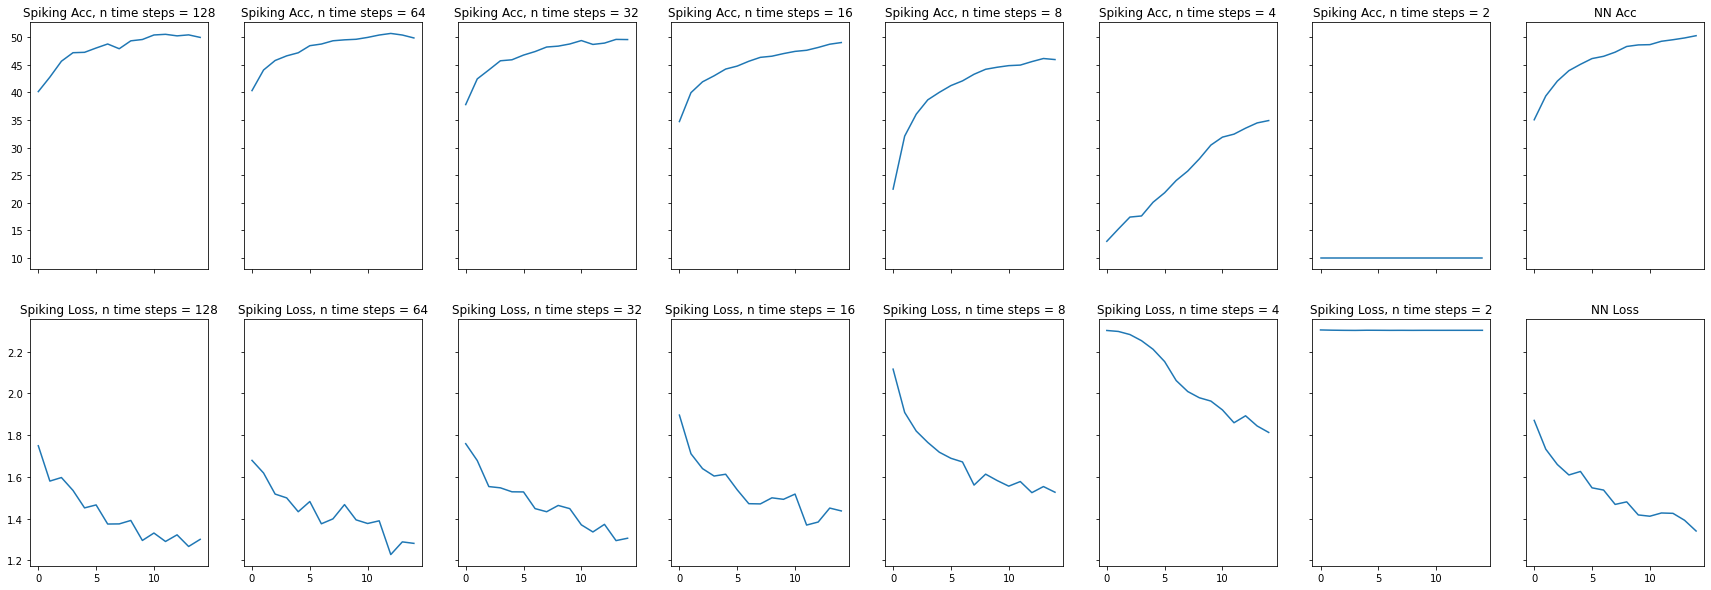

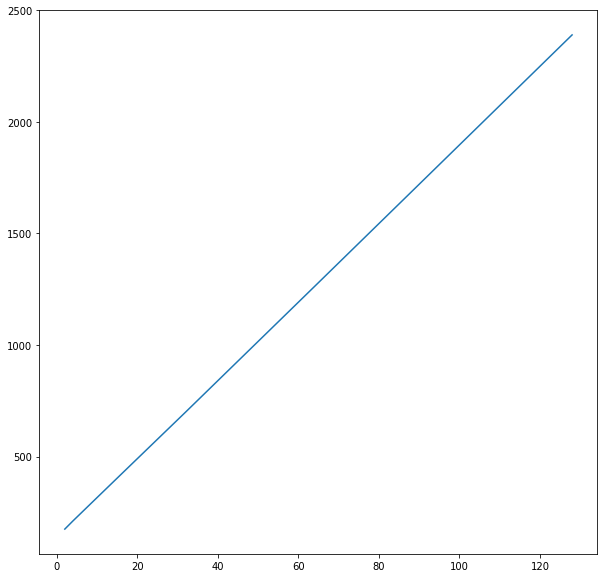

In [4]:
# Replicate original experiment on CIFAR10

###############################################################################
num_epoch = 15

time_step_list = [128/1,128/2,128/4,128/8,128/16,128/32,128/64]
total_time_models = []

fig, ax_lst = plt.subplots(2, len(time_step_list)+1, sharex=True, sharey='row',figsize=(30,10))

for i,step in enumerate(time_step_list):      
  spiking_model = SpikingNet(device, n_time_steps=int(step), begin_eval=0)
  loss, acc, time_m = train_many_epochs(spiking_model, epochs = num_epoch)
  total_time_models.append(time_m)
  ax_lst[0,i].plot(acc)
  ax_lst[0,i].set_title("Spiking Acc, n time steps = %d"%int(step))
  ax_lst[1,i].plot(loss)
  ax_lst[1,i].set_title("Spiking Loss, n time steps = %d"%int(step))

non_spiking_model = NonSpikingNet().to(device)
loss, acc, time_m = train_many_epochs(non_spiking_model, epochs = num_epoch)
ax_lst[0,len(time_step_list)].plot(acc)
ax_lst[0,len(time_step_list)].set_title("NN Acc")
ax_lst[1,len(time_step_list)].plot(loss)
ax_lst[1,len(time_step_list)].set_title("NN Loss")
plt.show()

plt.figure(figsize=(10,10))
plt.plot(time_step_list, total_time_models)
plt.show()



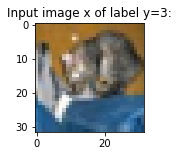

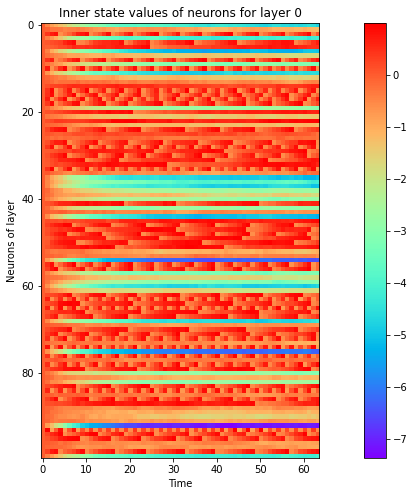

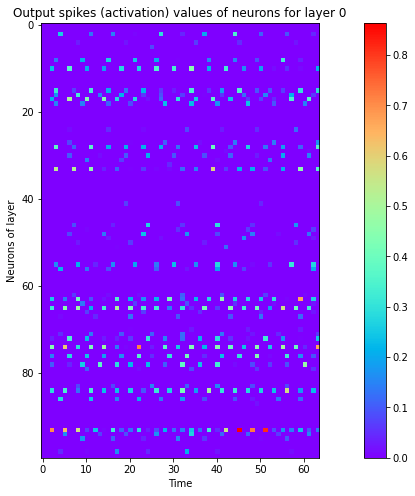

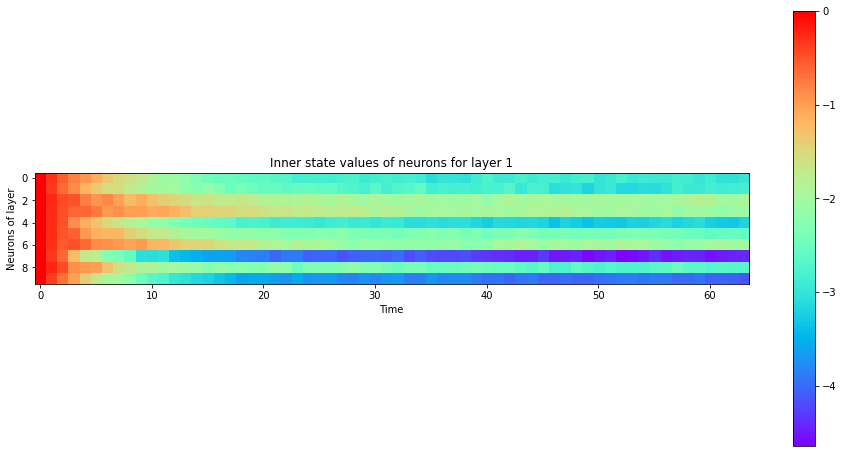

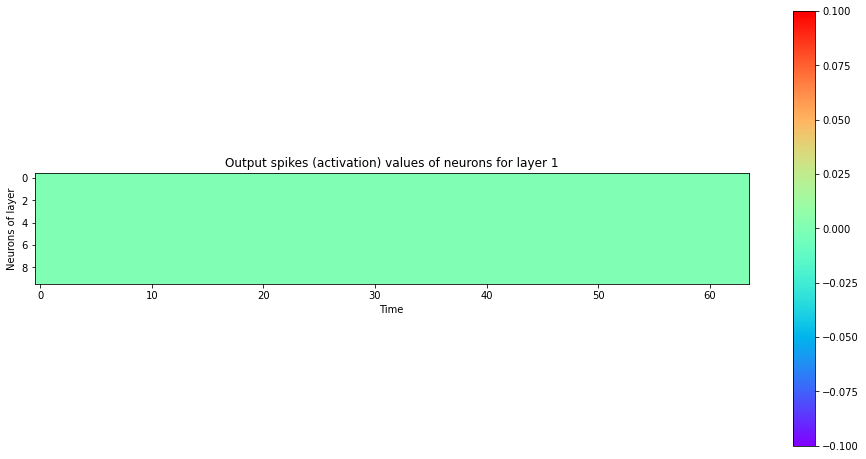

A hidden neuron that looks excited:


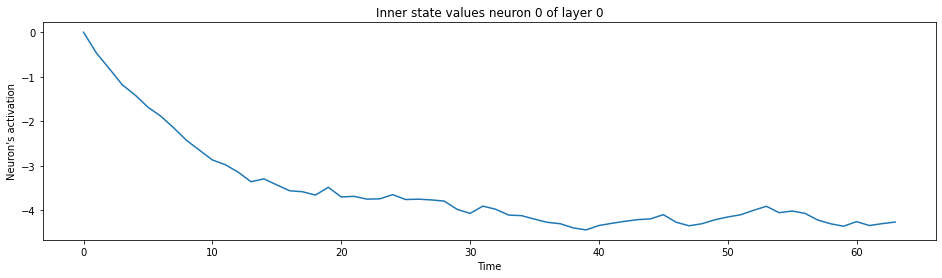

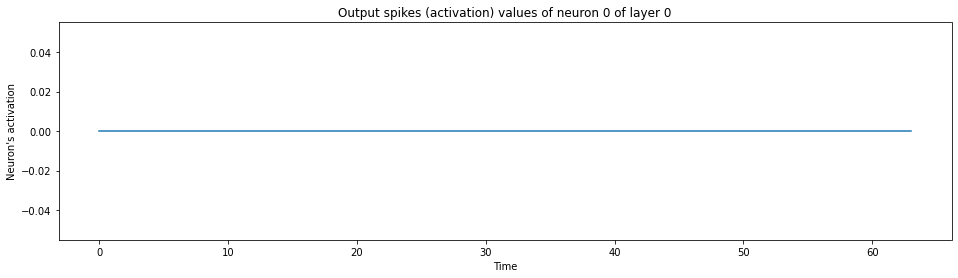

The output neuron of the label:


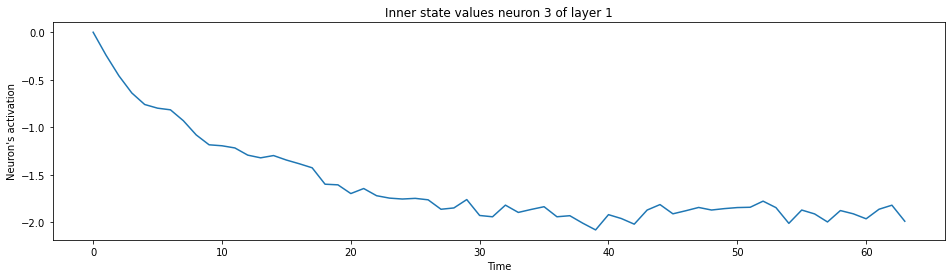

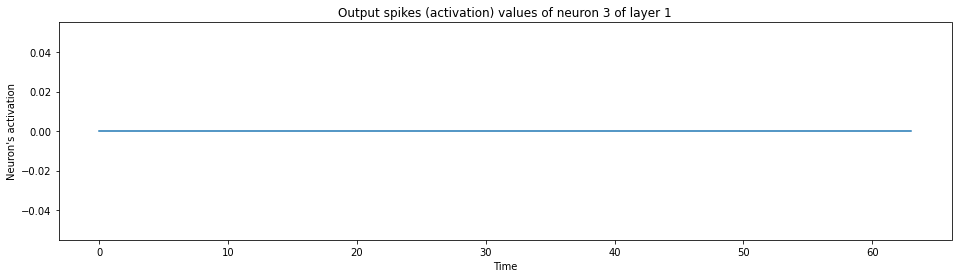

In [22]:
###############################################################################

import numpy as np

data, target = test_set_loader.__iter__().__next__()

# taking 1st testing example:
x = torch.stack([data[0]])
y = target.data.numpy()[0]
plt.figure(figsize=(2,2))
plt.imshow(x.data[0].cpu().numpy().transpose(1,2,0)+.5)
plt.title("Input image x of label y={}:".format(y))
plt.show()

# plotting neuron's activations:
spiking_model.visualize_all_neurons(x.to(device))
print("A hidden neuron that looks excited:")
spiking_model.visualize_neuron(x.to(device), layer_idx=0, neuron_idx=0)
print("The output neuron of the label:")
spiking_model.visualize_neuron(x.to(device), layer_idx=1, neuron_idx=y)

In [55]:
#Imports
import os
import matplotlib.pyplot as plt
import torchvision.datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.autograd import Variable


###############################################################################

def train(model, device, train_set_loader, optimizer, epoch, logging_interval=100):
    # This method is derived from: 
    # https://github.com/pytorch/examples/blob/master/mnist/main.py
    # Was licensed BSD-3-clause
    
    model.train()
    for batch_idx, (data, target) in enumerate(train_set_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % logging_interval == 0:
            pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct = pred.eq(target.view_as(pred)).float().mean().item()
            print('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f} Accuracy: {:.2f}%'.format(
                epoch, batch_idx * len(data), len(train_set_loader.dataset),
                100. * batch_idx / len(train_set_loader), loss.item(),
                100. * correct))
            
    return loss.item()

import time
def train_many_epochs(model, epochs = 10): 
    lr = 0.1
    start = time.time()
    loss_ot = []
    acc_ot = []
    for epoch in range(epochs):
      optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
      loss = train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
      acc = test(model, device, test_set_loader)
      loss_ot.append(loss)
      acc_ot.append(acc)
      lr = lr/2.0
    end = time.time()
    total_time = end - start
    print(total_time)
    return loss_ot, acc_ot, total_time

def test(model, device, test_set_loader):
    # This method is derived from: 
    # https://github.com/pytorch/examples/blob/master/mnist/main.py
    # Was licensed BSD-3-clause
    
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_set_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # Note: with `reduce=True`, I'm not sure what would happen with a final batch size 
            # that would be smaller than regular previous batch sizes. For now it works.
            test_loss += F.nll_loss(output, target, reduce=True).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_set_loader.dataset)
    print("")
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss, 
        correct, len(test_set_loader.dataset),
        100. * correct / len(test_set_loader.dataset)))
    print("")
    return 100. * correct / len(test_set_loader.dataset)

def download_CIFAR10(data_path):
    if not os.path.exists(data_path):
        os.mkdir(data_path)
    transformation = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
    training_set = torchvision.datasets.CIFAR10(data_path, train=True, transform=transformation, download=True)
    testing_set = torchvision.datasets.CIFAR10(data_path, train=False, transform=transformation, download=True)
    return training_set, testing_set

###############################################################################

batch_size = 1000
DATA_PATH = './data'

training_set, testing_set = download_CIFAR10(DATA_PATH)
train_set_loader = torch.utils.data.DataLoader(
    dataset=training_set,
    batch_size=batch_size,
    shuffle=True)
test_set_loader = torch.utils.data.DataLoader(
    dataset=testing_set,
    batch_size=batch_size,
    shuffle=False)

###############################################################################

# Use GPU whever possible!
import torch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

###############################################################################

class SpikingNeuronLayerRNN(nn.Module):
    
    def __init__(self, device, n_inputs=28*28, n_hidden=100, decay_multiplier=0.9, threshold=2.0, penalty_threshold=2.5):
        super(SpikingNeuronLayerRNN, self).__init__()
        self.device = device
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.decay_multiplier = decay_multiplier
        self.threshold = threshold
        self.penalty_threshold = penalty_threshold
        
        self.fc = nn.Linear(n_inputs, n_hidden)
        
        self.init_parameters()
        self.reset_state()
        self.to(self.device)
        
    def init_parameters(self):
        for param in self.parameters():
            if param.dim() >= 2:
                nn.init.xavier_uniform_(param)
        
    def reset_state(self):
        self.prev_inner = torch.zeros([self.n_hidden]).to(self.device)
        self.prev_outer = torch.zeros([self.n_hidden]).to(self.device)

    def forward(self, x):
        """
        Call the neuron at every time step.
        
        x: activated_neurons_below
        
        return: a tuple of (state, output) for each time step. Each item in the tuple
        are then themselves of shape (batch_size, n_hidden) and are PyTorch objects, such 
        that the whole returned would be of shape (2, batch_size, n_hidden) if casted.
        """
        if self.prev_inner.dim() == 1:
            # Adding batch_size dimension directly after doing a `self.reset_state()`:
            batch_size = x.shape[0]
            self.prev_inner = torch.stack(batch_size * [self.prev_inner])
            self.prev_outer = torch.stack(batch_size * [self.prev_outer])
        
        # 1. Weight matrix multiplies the input x
        input_excitation = self.fc(x)
        
        # 2. We add the result to a decayed version of the information we already had.
        inner_excitation = input_excitation + self.prev_inner * self.decay_multiplier
        
        # 3. We compute the activation of the neuron to find its output value, 
        #    but before the activation, there is also a negative bias that refrain thing from firing too much.
        outer_excitation = F.relu(inner_excitation - self.threshold)
        
        # 4. If the neuron fires, the activation of the neuron is subtracted to its inner state 
        #    (and with an extra penalty for increase refractory time), 
        #    because it discharges naturally so it shouldn't fire twice. 
        do_penalize_gate = (outer_excitation > 0).float()
        # TODO: remove following /2?
        inner_excitation = inner_excitation - (self.penalty_threshold/self.threshold * inner_excitation) * do_penalize_gate
        
        # 5. The outer excitation has a negative part after the positive part. 
        outer_excitation = outer_excitation #+ torch.abs(self.prev_outer) * self.decay_multiplier / 2.0
        
        # 6. Setting internal values before returning. 
        #    And the returning value is the one of the previous time step to delay 
        #    activation of 1 time step of "processing" time. For logits, we don't take activation.
        delayed_return_state = self.prev_inner
        delayed_return_output = self.prev_outer
        self.prev_inner = inner_excitation
        self.prev_outer = outer_excitation
        return delayed_return_state, delayed_return_output
    

###############################################################################

class SpikingNeuronLayerCRNN(nn.Module):
    
    def __init__(self, device, n_hidden=64, decay_multiplier=0.9, threshold=2.0, penalty_threshold=2.5):
        super(SpikingNeuronLayerCRNN, self).__init__()
        self.device = device
        self.n_hidden = n_hidden
        self.decay_multiplier = decay_multiplier
        self.threshold = threshold
        self.penalty_threshold = penalty_threshold
        
        self.conv = torch.nn.Sequential(
                              nn.Conv2d(3, 6, 5),
                              nn.ReLU(),
                              nn.MaxPool2d(2, 2),
                              nn.Conv2d(6, 12, 5),
                              nn.ReLU(),
        )
        self.fc = torch.nn.Sequential(
                              nn.Linear(12 * 10 * 10, 100),
                              nn.ReLU()
        )
                        
        self.init_parameters()
        self.reset_state()
        self.to(self.device)
        
    def init_parameters(self):
        for param in self.parameters():
            if param.dim() >= 2:
                nn.init.xavier_uniform_(param)
        
    def reset_state(self):
        self.prev_inner = torch.zeros([self.n_hidden]).to(self.device)
        self.prev_outer = torch.zeros([self.n_hidden]).to(self.device)

    def forward(self, x):
        """
        Call the neuron at every time step.
        
        x: activated_neurons_below
        
        return: a tuple of (state, output) for each time step. Each item in the tuple
        are then themselves of shape (batch_size, n_hidden) and are PyTorch objects, such 
        that the whole returned would be of shape (2, batch_size, n_hidden) if casted.
        """
        if self.prev_inner.dim() == 1:
            # Adding batch_size dimension directly after doing a `self.reset_state()`:
            batch_size = x.shape[0]
            self.prev_inner = torch.stack(batch_size * [self.prev_inner])
            self.prev_outer = torch.stack(batch_size * [self.prev_outer])
        
        # 1. Weight matrix multiplies the input x
        conv_excitation = self.conv(x)
        conv_excitation = conv_excitation.view(-1, 12 * 10 * 10)
        input_excitation = self.fc(conv_excitation)
        
        # 2. We add the result to a decayed version of the information we already had.
        inner_excitation = input_excitation + self.prev_inner * self.decay_multiplier
        
        # 3. We compute the activation of the neuron to find its output value, 
        #    but before the activation, there is also a negative bias that refrain thing from firing too much.
        outer_excitation = F.relu(inner_excitation - self.threshold)
        
        # 4. If the neuron fires, the activation of the neuron is subtracted to its inner state 
        #    (and with an extra penalty for increase refractory time), 
        #    because it discharges naturally so it shouldn't fire twice. 
        do_penalize_gate = (outer_excitation > 0).float()
        # TODO: remove following /2?
        inner_excitation = inner_excitation - (self.penalty_threshold/self.threshold * inner_excitation) * do_penalize_gate
        
        # 5. The outer excitation has a negative part after the positive part. 
        outer_excitation = outer_excitation #+ torch.abs(self.prev_outer) * self.decay_multiplier / 2.0
        
        # 6. Setting internal values before returning. 
        #    And the returning value is the one of the previous time step to delay 
        #    activation of 1 time step of "processing" time. For logits, we don't take activation.
        delayed_return_state = self.prev_inner
        delayed_return_output = self.prev_outer
        self.prev_inner = inner_excitation
        self.prev_outer = outer_excitation
        return delayed_return_state, delayed_return_output
    
###############################################################################
        
class InputDataToSpikingPerceptronLayer(nn.Module):
    
    def __init__(self, device):
        super(InputDataToSpikingPerceptronLayer, self).__init__()
        self.device = device
        
        self.reset_state()
        self.to(self.device)
        
    def reset_state(self):
        #     self.prev_state = torch.zeros([self.n_hidden]).to(self.device)
        pass
    
    def forward(self, x, is_2D=True):
        #x = x.view(x.size(0), -1)  # Flatten 2D image to 1D for FC
        random_activation_perceptron = torch.rand(x.shape).to(self.device)
        return random_activation_perceptron * x
    
###############################################################################

class OutputDataToSpikingPerceptronLayer(nn.Module):
    
    def __init__(self, average_output=True):
        """
        average_output: might be needed if this is used within a regular neural net as a layer.
        Otherwise, sum may be numerically more stable for gradients with setting average_output=False.
        """
        super(OutputDataToSpikingPerceptronLayer, self).__init__()
        if average_output:
            self.reducer = lambda x, dim: x.sum(dim=dim)
        else:
            self.reducer = lambda x, dim: x.mean(dim=dim)
    
    def forward(self, x):
        if type(x) == list:
            x = torch.stack(x)
        return self.reducer(x, 0)
    
###############################################################################
        
class SpikingConvNet(nn.Module):
    
    def __init__(self, device, n_time_steps, begin_eval):
        super(SpikingConvNet, self).__init__()
        assert (0 <= begin_eval and begin_eval < n_time_steps)
        self.device = device
        self.n_time_steps = n_time_steps
        self.begin_eval = begin_eval
        
        self.input_conversion = InputDataToSpikingPerceptronLayer(device)
        
        self.layer1 = SpikingNeuronLayerCRNN(
            device, n_hidden=100,
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
        
        self.layer2 = SpikingNeuronLayerRNN(
            device, n_inputs=100, n_hidden=10,
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
        
        self.output_conversion = OutputDataToSpikingPerceptronLayer(average_output=False)  # Sum on outputs.
        
        self.to(self.device)
    
    def forward_through_time(self, x):
        """
        This acts as a layer. Its input is non-time-related, and its output too.
        So the time iterations happens inside, and the returned layer is thus
        passed through global average pooling on the time axis before the return 
        such as to be able to mix this pipeline with regular backprop layers such
        as the input data and the output data.
        """
        self.input_conversion.reset_state()
        self.layer1.reset_state()
        self.layer2.reset_state()

        out = []
        
        all_layer1_states = []
        all_layer1_outputs = []
        all_layer2_states = []
        all_layer2_outputs = []
        for _ in range(self.n_time_steps):
            xi = self.input_conversion(x)
            
            # For layer 1, we take the regular output.
            layer1_state, layer1_output = self.layer1(xi)
            
            # We take inner state of layer 2 because it's pre-activation and thus acts as out logits.
            layer2_state, layer2_output = self.layer2(layer1_output)
            
            all_layer1_states.append(layer1_state)
            all_layer1_outputs.append(layer1_output)
            all_layer2_states.append(layer2_state)
            all_layer2_outputs.append(layer2_output)
            out.append(layer2_state)
            
        out = self.output_conversion(out[self.begin_eval:])
        return out, [[all_layer1_states, all_layer1_outputs], [all_layer2_states, all_layer2_outputs]]
    
    def forward(self, x):
        out, _ = self.forward_through_time(x)
        return F.log_softmax(out, dim=-1)

    def visualize_all_neurons(self, x):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to SpikingNet.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        for i, (all_layer_states, all_layer_outputs) in enumerate(layers_state):
            layer_state  =  torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
            layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()
            
            self.plot_layer(layer_state, title="Inner state values of neurons for layer {}".format(i))
            self.plot_layer(layer_output, title="Output spikes (activation) values of neurons for layer {}".format(i))
    
    def visualize_neuron(self, x, layer_idx, neuron_idx):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to SpikingNet.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        all_layer_states, all_layer_outputs = layers_state[layer_idx]
        layer_state  =  torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
        layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()

        self.plot_neuron(layer_state[neuron_idx], title="Inner state values neuron {} of layer {}".format(neuron_idx, layer_idx))
        self.plot_neuron(layer_output[neuron_idx], title="Output spikes (activation) values of neuron {} of layer {}".format(neuron_idx, layer_idx))

    def plot_layer(self, layer_values, title):
        """
        This function is derived from: 
            https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition 
        Which was released under the MIT License. 
        """
        width = max(16, layer_values.shape[0] / 8)
        height = max(4, layer_values.shape[1] / 8)
        plt.figure(figsize=(width, height))
        plt.imshow(
            layer_values,
            interpolation="nearest",
            cmap=plt.cm.rainbow
        )
        plt.title(title)
        plt.colorbar()
        plt.xlabel("Time")
        plt.ylabel("Neurons of layer")
        plt.show()

    def plot_neuron(self, neuron_through_time, title):
        width = max(16, len(neuron_through_time) / 8)
        height = 4
        plt.figure(figsize=(width, height))
        plt.title(title)
        plt.plot(neuron_through_time)
        plt.xlabel("Time")
        plt.ylabel("Neuron's activation")
        plt.show()

###############################################################################


class NonSpikingNet(nn.Module):
    
    def __init__(self):
        super(NonSpikingNet, self).__init__()
        self.layer1 = nn.Linear(3* 32* 32, 100)
        self.layer2 = nn.Linear(100, 10)

    def forward(self, x, is_2D=True):
        x = x.view(x.size(0), -1)  # Flatten 2D image to 1D for FC
        x = F.relu(self.layer1(x))
        x =        self.layer2(x)
        return F.log_softmax(x, dim=-1)

Files already downloaded and verified
Files already downloaded and verified


Train Epoch: 0 [0/50000 (0%)] Loss: 2.391170 Accuracy: 12.30%
Train Epoch: 0 [10000/50000 (20%)] Loss: 2.430050 Accuracy: 10.40%
Train Epoch: 0 [20000/50000 (40%)] Loss: 2.296350 Accuracy: 18.10%
Train Epoch: 0 [30000/50000 (60%)] Loss: 2.076389 Accuracy: 23.00%
Train Epoch: 0 [40000/50000 (80%)] Loss: 2.352346 Accuracy: 16.80%


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0020, Accuracy: 2845/10000 (28.45%)

Train Epoch: 1 [0/50000 (0%)] Loss: 2.000186 Accuracy: 30.60%
Train Epoch: 1 [10000/50000 (20%)] Loss: 1.908152 Accuracy: 31.20%
Train Epoch: 1 [20000/50000 (40%)] Loss: 2.024571 Accuracy: 29.20%
Train Epoch: 1 [30000/50000 (60%)] Loss: 2.101463 Accuracy: 30.60%
Train Epoch: 1 [40000/50000 (80%)] Loss: 1.872563 Accuracy: 35.10%

Test set: Average loss: 0.0018, Accuracy: 3659/10000 (36.59%)

Train Epoch: 2 [0/50000 (0%)] Loss: 1.753348 Accuracy: 37.70%
Train Epoch: 2 [10000/50000 (20%)] Loss: 1.996452 Accuracy: 28.70%
Train Epoch: 2 [20000/50000 (40%)] Loss: 1.679247 Accuracy: 38.60%
Train Epoch: 2 [30000/50000 (60%)] Loss: 2.117102 Accuracy: 26.60%
Train Epoch: 2 [40000/50000 (80%)] Loss: 1.664685 Accuracy: 41.10%

Test set: Average loss: 0.0017, Accuracy: 4040/10000 (40.40%)

Train Epoch: 3 [0/50000 (0%)] Loss: 1.638229 Accuracy: 39.50%
Train Epoch: 3 [10000/50000 (20%)] Loss: 1.706066 Accuracy: 36.60%
Train Epoch: 3 [200

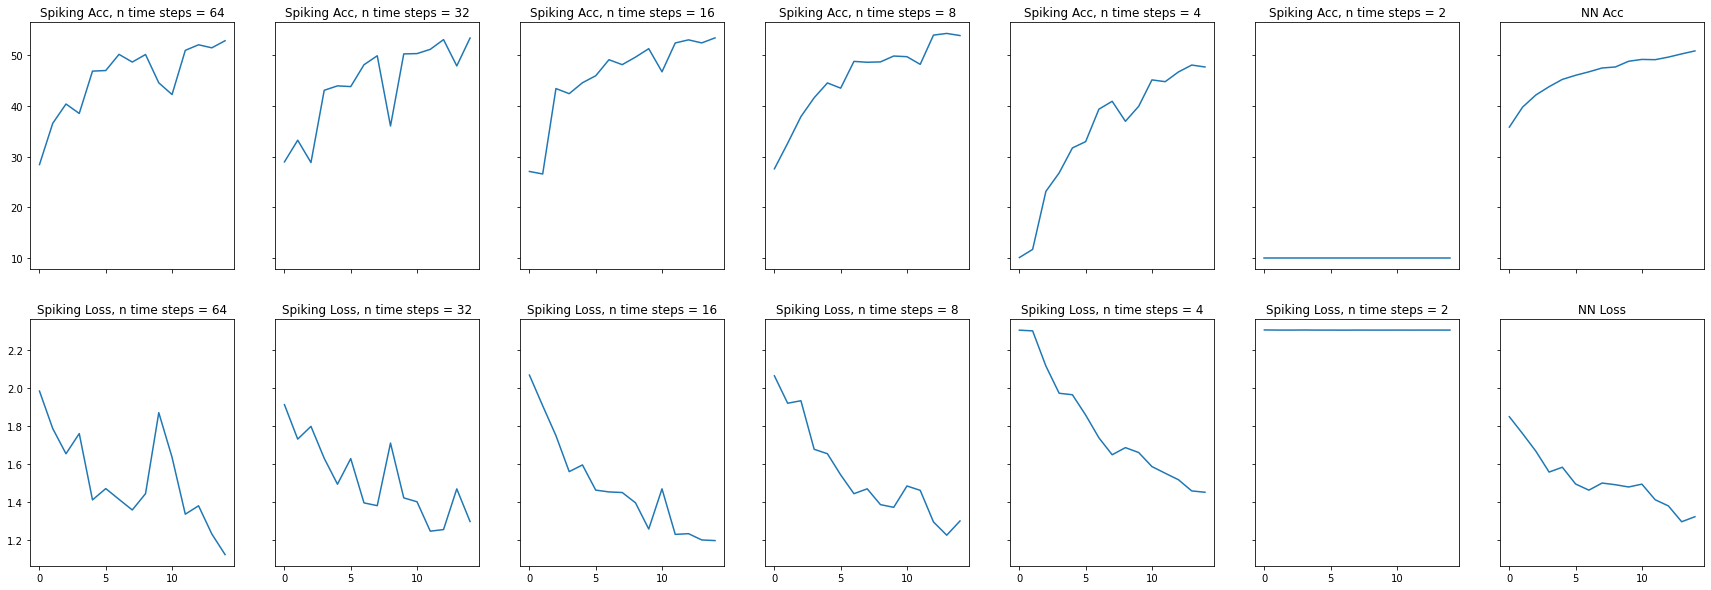

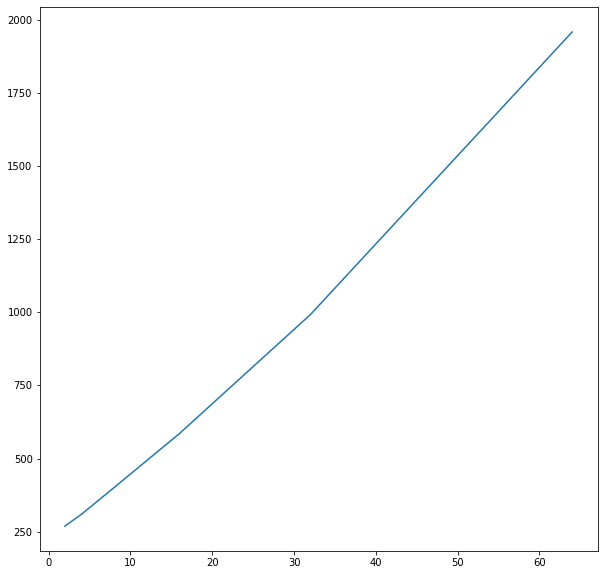

In [61]:
###############################################################################
        
num_epoch = 15

time_step_list = [128/2,128/4,128/8,128/16,128/32,128/64]
total_time_models = []

fig, ax_lst = plt.subplots(2, len(time_step_list)+1, sharex=True, sharey='row',figsize=(30,10))

for i,step in enumerate(time_step_list):      
  spiking_model = SpikingConvNet(device, n_time_steps=int(step), begin_eval=0)
  loss, acc, time_m = train_many_epochs(spiking_model, epochs = num_epoch)
  total_time_models.append(time_m)
  ax_lst[0,i].plot(acc)
  ax_lst[0,i].set_title("Spiking Acc, n time steps = %d"%int(step))
  ax_lst[1,i].plot(loss)
  ax_lst[1,i].set_title("Spiking Loss, n time steps = %d"%int(step))

non_spiking_model = NonSpikingNet().to(device)
loss, acc, time_m = train_many_epochs(non_spiking_model, epochs = num_epoch)
ax_lst[0,len(time_step_list)].plot(acc)
ax_lst[0,len(time_step_list)].set_title("NN Acc")
ax_lst[1,len(time_step_list)].plot(loss)
ax_lst[1,len(time_step_list)].set_title("NN Loss")
plt.show()

plt.figure(figsize=(10,10))
plt.plot(time_step_list, total_time_models)
plt.show()




In [0]:
###############################################################################

data, target = test_set_loader.__iter__().__next__()

# taking 1st testing example:
x = torch.stack([data[0]])
y = target.data.numpy()[0]
plt.figure(figsize=(12,12))
plt.imshow(x.data.cpu().numpy()[0,0])
plt.title("Input image x of label y={}:".format(y))
plt.show()

# plotting neuron's activations:
spiking_model.visualize_all_neurons(x)
print("A hidden neuron that looks excited:")
spiking_model.visualize_neuron(x, layer_idx=0, neuron_idx=0)
print("The output neuron of the label:")
spiking_model.visualize_neuron(x, layer_idx=1, neuron_idx=y)

MNIST

In [0]:
#Imports
import os
import matplotlib.pyplot as plt
import torchvision.datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.autograd import Variable


###############################################################################

def train(model, device, train_set_loader, optimizer, epoch, logging_interval=100):
    # This method is derived from: 
    # https://github.com/pytorch/examples/blob/master/mnist/main.py
    # Was licensed BSD-3-clause
    
    model.train()
    for batch_idx, (data, target) in enumerate(train_set_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % logging_interval == 0:
            pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct = pred.eq(target.view_as(pred)).float().mean().item()
            print('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f} Accuracy: {:.2f}%'.format(
                epoch, batch_idx * len(data), len(train_set_loader.dataset),
                100. * batch_idx / len(train_set_loader), loss.item(),
                100. * correct))
            
    return loss.item()

import time
def train_many_epochs(model, epochs = 10): 
    lr = 0.1
    start = time.time()
    loss_ot = []
    acc_ot = []
    for epoch in range(epochs):
      optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
      loss = train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
      acc = test(model, device, test_set_loader)
      loss_ot.append(loss)
      acc_ot.append(acc)
      lr = lr/2.0
    end = time.time()
    total_time = end - start
    print(total_time)
    return loss_ot, acc_ot, total_time

def test(model, device, test_set_loader):
    # This method is derived from: 
    # https://github.com/pytorch/examples/blob/master/mnist/main.py
    # Was licensed BSD-3-clause
    
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_set_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # Note: with `reduce=True`, I'm not sure what would happen with a final batch size 
            # that would be smaller than regular previous batch sizes. For now it works.
            test_loss += F.nll_loss(output, target, reduce=True).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_set_loader.dataset)
    print("")
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss, 
        correct, len(test_set_loader.dataset),
        100. * correct / len(test_set_loader.dataset)))
    print("")
    return 100. * correct / len(test_set_loader.dataset)

def download_mnist(data_path):
    if not os.path.exists(data_path):
        os.mkdir(data_path)
    transformation = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
    training_set = torchvision.datasets.MNIST(data_path, train=True, transform=transformation, download=True)
    testing_set = torchvision.datasets.MNIST(data_path, train=False, transform=transformation, download=True)
    return training_set, testing_set

###############################################################################

batch_size = 1000
DATA_PATH = './data'

training_set, testing_set = download_mnist(DATA_PATH)
train_set_loader = torch.utils.data.DataLoader(
    dataset=training_set,
    batch_size=batch_size,
    shuffle=True)
test_set_loader = torch.utils.data.DataLoader(
    dataset=testing_set,
    batch_size=batch_size,
    shuffle=False)

###############################################################################

# Use GPU whever possible!
import torch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

###############################################################################

class SpikingNeuronLayerRNN(nn.Module):
    
    def __init__(self, device, n_inputs=28*28, n_hidden=100, decay_multiplier=0.9, threshold=2.0, penalty_threshold=2.5):
        super(SpikingNeuronLayerRNN, self).__init__()
        self.device = device
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.decay_multiplier = decay_multiplier
        self.threshold = threshold
        self.penalty_threshold = penalty_threshold
        
        self.fc = nn.Linear(n_inputs, n_hidden)
        
        self.init_parameters()
        self.reset_state()
        self.to(self.device)
        
    def init_parameters(self):
        for param in self.parameters():
            if param.dim() >= 2:
                nn.init.xavier_uniform_(param)
        
    def reset_state(self):
        self.prev_inner = torch.zeros([self.n_hidden]).to(self.device)
        self.prev_outer = torch.zeros([self.n_hidden]).to(self.device)

    def forward(self, x):
        """
        Call the neuron at every time step.
        
        x: activated_neurons_below
        
        return: a tuple of (state, output) for each time step. Each item in the tuple
        are then themselves of shape (batch_size, n_hidden) and are PyTorch objects, such 
        that the whole returned would be of shape (2, batch_size, n_hidden) if casted.
        """
        if self.prev_inner.dim() == 1:
            # Adding batch_size dimension directly after doing a `self.reset_state()`:
            batch_size = x.shape[0]
            self.prev_inner = torch.stack(batch_size * [self.prev_inner])
            self.prev_outer = torch.stack(batch_size * [self.prev_outer])
        
        # 1. Weight matrix multiplies the input x
        input_excitation = self.fc(x)
        
        # 2. We add the result to a decayed version of the information we already had.
        inner_excitation = input_excitation + self.prev_inner * self.decay_multiplier
        
        # 3. We compute the activation of the neuron to find its output value, 
        #    but before the activation, there is also a negative bias that refrain thing from firing too much.
        outer_excitation = F.relu(inner_excitation - self.threshold)
        
        # 4. If the neuron fires, the activation of the neuron is subtracted to its inner state 
        #    (and with an extra penalty for increase refractory time), 
        #    because it discharges naturally so it shouldn't fire twice. 
        do_penalize_gate = (outer_excitation > 0).float()
        # TODO: remove following /2?
        inner_excitation = inner_excitation - (self.penalty_threshold/self.threshold * inner_excitation) * do_penalize_gate
        
        # 5. The outer excitation has a negative part after the positive part. 
        outer_excitation = outer_excitation #+ torch.abs(self.prev_outer) * self.decay_multiplier / 2.0
        
        # 6. Setting internal values before returning. 
        #    And the returning value is the one of the previous time step to delay 
        #    activation of 1 time step of "processing" time. For logits, we don't take activation.
        delayed_return_state = self.prev_inner
        delayed_return_output = self.prev_outer
        self.prev_inner = inner_excitation
        self.prev_outer = outer_excitation
        return delayed_return_state, delayed_return_output
    
###############################################################################
        
class InputDataToSpikingPerceptronLayer(nn.Module):
    
    def __init__(self, device):
        super(InputDataToSpikingPerceptronLayer, self).__init__()
        self.device = device
        
        self.reset_state()
        self.to(self.device)
        
    def reset_state(self):
        #     self.prev_state = torch.zeros([self.n_hidden]).to(self.device)
        pass
    
    def forward(self, x, is_2D=True):
        x = x.view(x.size(0), -1)  # Flatten 2D image to 1D for FC
        random_activation_perceptron = torch.rand(x.shape).to(self.device)
        return random_activation_perceptron * x
    
###############################################################################

class OutputDataToSpikingPerceptronLayer(nn.Module):
    
    def __init__(self, average_output=True):
        """
        average_output: might be needed if this is used within a regular neural net as a layer.
        Otherwise, sum may be numerically more stable for gradients with setting average_output=False.
        """
        super(OutputDataToSpikingPerceptronLayer, self).__init__()
        if average_output:
            self.reducer = lambda x, dim: x.sum(dim=dim)
        else:
            self.reducer = lambda x, dim: x.mean(dim=dim)
    
    def forward(self, x):
        if type(x) == list:
            x = torch.stack(x)
        return self.reducer(x, 0)
    
###############################################################################
        
class SpikingNet(nn.Module):
    
    def __init__(self, device, n_time_steps, begin_eval):
        super(SpikingNet, self).__init__()
        assert (0 <= begin_eval and begin_eval < n_time_steps)
        self.device = device
        self.n_time_steps = n_time_steps
        self.begin_eval = begin_eval
        
        self.input_conversion = InputDataToSpikingPerceptronLayer(device)
        
        self.layer1 = SpikingNeuronLayerRNN(
            device, n_inputs=1*28*28, n_hidden=100,
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
        
        self.layer2 = SpikingNeuronLayerRNN(
            device, n_inputs=100, n_hidden=10,
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
        
        self.output_conversion = OutputDataToSpikingPerceptronLayer(average_output=False)  # Sum on outputs.
        
        self.to(self.device)
    
    def forward_through_time(self, x):
        """
        This acts as a layer. Its input is non-time-related, and its output too.
        So the time iterations happens inside, and the returned layer is thus
        passed through global average pooling on the time axis before the return 
        such as to be able to mix this pipeline with regular backprop layers such
        as the input data and the output data.
        """
        self.input_conversion.reset_state()
        self.layer1.reset_state()
        self.layer2.reset_state()

        out = []
        
        all_layer1_states = []
        all_layer1_outputs = []
        all_layer2_states = []
        all_layer2_outputs = []
        for _ in range(self.n_time_steps):
            xi = self.input_conversion(x)
            
            # For layer 1, we take the regular output.
            layer1_state, layer1_output = self.layer1(xi)
            
            # We take inner state of layer 2 because it's pre-activation and thus acts as out logits.
            layer2_state, layer2_output = self.layer2(layer1_output)
            
            all_layer1_states.append(layer1_state)
            all_layer1_outputs.append(layer1_output)
            all_layer2_states.append(layer2_state)
            all_layer2_outputs.append(layer2_output)
            out.append(layer2_state)
            
        out = self.output_conversion(out[self.begin_eval:])
        return out, [[all_layer1_states, all_layer1_outputs], [all_layer2_states, all_layer2_outputs]]
    
    def forward(self, x):
        out, _ = self.forward_through_time(x)
        return F.log_softmax(out, dim=-1)

    def visualize_all_neurons(self, x):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to SpikingNet.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        for i, (all_layer_states, all_layer_outputs) in enumerate(layers_state):
            layer_state  =  torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
            layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()
            
            self.plot_layer(layer_state, title="Inner state values of neurons for layer {}".format(i))
            self.plot_layer(layer_output, title="Output spikes (activation) values of neurons for layer {}".format(i))
    
    def visualize_neuron(self, x, layer_idx, neuron_idx):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to SpikingNet.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        all_layer_states, all_layer_outputs = layers_state[layer_idx]
        layer_state  =  torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
        layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()

        self.plot_neuron(layer_state[neuron_idx], title="Inner state values neuron {} of layer {}".format(neuron_idx, layer_idx))
        self.plot_neuron(layer_output[neuron_idx], title="Output spikes (activation) values of neuron {} of layer {}".format(neuron_idx, layer_idx))

    def plot_layer(self, layer_values, title):
        """
        This function is derived from: 
            https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition 
        Which was released under the MIT License. 
        """
        width = max(16, layer_values.shape[0] / 8)
        height = max(4, layer_values.shape[1] / 8)
        plt.figure(figsize=(width, height))
        plt.imshow(
            layer_values,
            interpolation="nearest",
            cmap=plt.cm.rainbow
        )
        plt.title(title)
        plt.colorbar()
        plt.xlabel("Time")
        plt.ylabel("Neurons of layer")
        plt.show()

    def plot_neuron(self, neuron_through_time, title):
        width = max(16, len(neuron_through_time) / 8)
        height = 4
        plt.figure(figsize=(width, height))
        plt.title(title)
        plt.plot(neuron_through_time)
        plt.xlabel("Time")
        plt.ylabel("Neuron's activation")
        plt.show()

###############################################################################


class NonSpikingNet(nn.Module):
    
    def __init__(self):
        super(NonSpikingNet, self).__init__()
        self.layer1 = nn.Linear(1* 28* 28, 100)
        self.layer2 = nn.Linear(100, 10)

    def forward(self, x, is_2D=True):
        x = x.view(x.size(0), -1)  # Flatten 2D image to 1D for FC
        x = F.relu(self.layer1(x))
        x =        self.layer2(x)
        return F.log_softmax(x, dim=-1)

Train Epoch: 0 [0/60000 (0%)] Loss: 2.472577 Accuracy: 8.00%
Train Epoch: 0 [10000/60000 (17%)] Loss: 1.875361 Accuracy: 20.10%
Train Epoch: 0 [20000/60000 (33%)] Loss: 1.520255 Accuracy: 47.90%
Train Epoch: 0 [30000/60000 (50%)] Loss: 0.622127 Accuracy: 81.30%
Train Epoch: 0 [40000/60000 (67%)] Loss: 0.549899 Accuracy: 80.30%
Train Epoch: 0 [50000/60000 (83%)] Loss: 0.427159 Accuracy: 87.40%


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0004, Accuracy: 8897/10000 (88.97%)

Train Epoch: 1 [0/60000 (0%)] Loss: 0.364843 Accuracy: 89.40%
Train Epoch: 1 [10000/60000 (17%)] Loss: 0.375543 Accuracy: 86.40%
Train Epoch: 1 [20000/60000 (33%)] Loss: 0.369272 Accuracy: 89.20%
Train Epoch: 1 [30000/60000 (50%)] Loss: 0.419180 Accuracy: 86.70%
Train Epoch: 1 [40000/60000 (67%)] Loss: 0.364053 Accuracy: 89.20%
Train Epoch: 1 [50000/60000 (83%)] Loss: 0.334711 Accuracy: 90.20%

Test set: Average loss: 0.0003, Accuracy: 9081/10000 (90.81%)

Train Epoch: 2 [0/60000 (0%)] Loss: 0.316079 Accuracy: 90.40%
Train Epoch: 2 [10000/60000 (17%)] Loss: 0.322666 Accuracy: 90.40%
Train Epoch: 2 [20000/60000 (33%)] Loss: 0.311312 Accuracy: 90.00%
Train Epoch: 2 [30000/60000 (50%)] Loss: 0.335567 Accuracy: 91.00%
Train Epoch: 2 [40000/60000 (67%)] Loss: 0.298373 Accuracy: 91.50%
Train Epoch: 2 [50000/60000 (83%)] Loss: 0.287188 Accuracy: 92.50%

Test set: Average loss: 0.0003, Accuracy: 9181/10000 (91.81%)

Train Epoch: 3

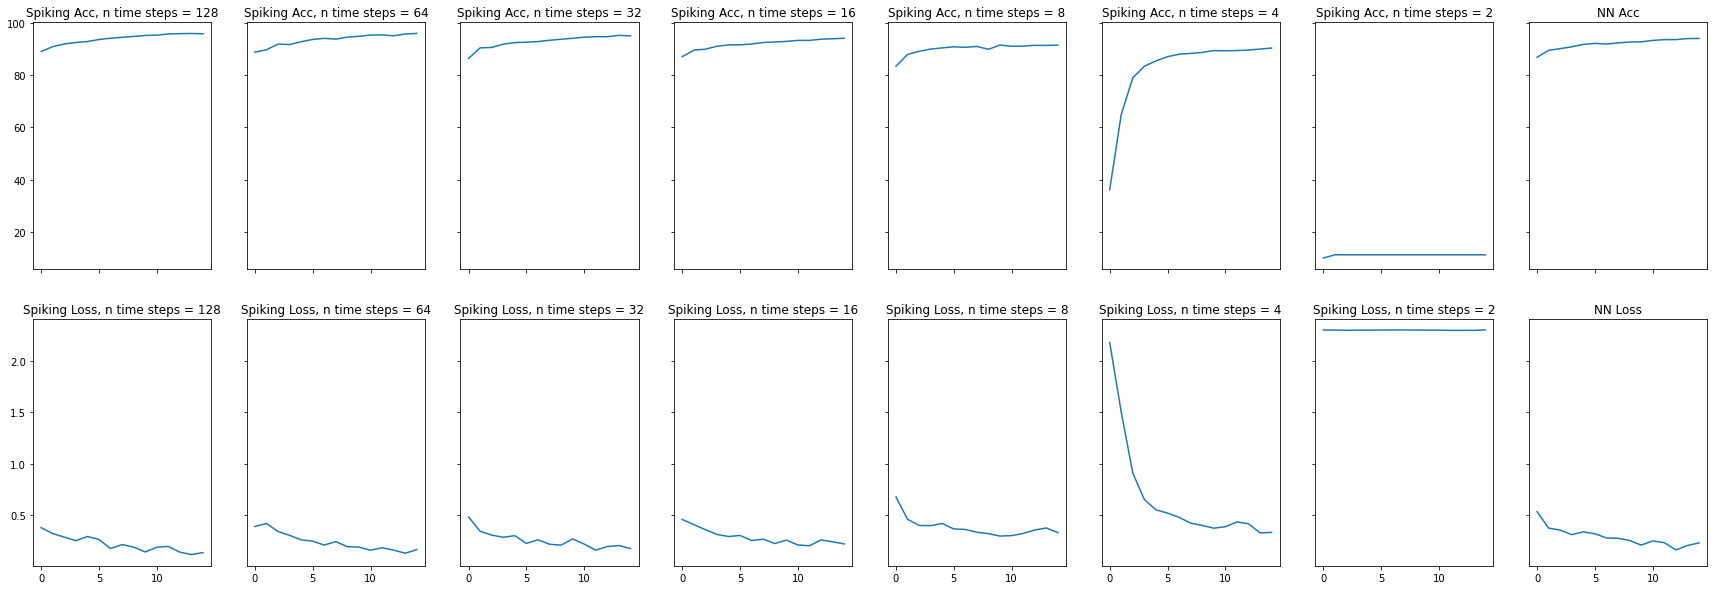

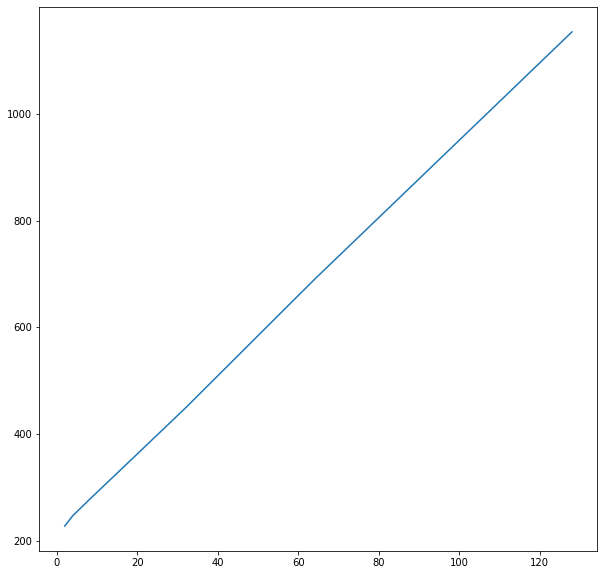

In [65]:
# Replicate original experiment (MNIST)

###############################################################################
num_epoch = 15

time_step_list = [128/1,128/2,128/4,128/8,128/16,128/32,128/64]
total_time_models = []

fig, ax_lst = plt.subplots(2, len(time_step_list)+1, sharex=True, sharey='row',figsize=(30,10))

for i,step in enumerate(time_step_list):      
  spiking_model = SpikingNet(device, n_time_steps=int(step), begin_eval=0)
  loss, acc, time_m = train_many_epochs(spiking_model, epochs = num_epoch)
  total_time_models.append(time_m)
  ax_lst[0,i].plot(acc)
  ax_lst[0,i].set_title("Spiking Acc, n time steps = %d"%int(step))
  ax_lst[1,i].plot(loss)
  ax_lst[1,i].set_title("Spiking Loss, n time steps = %d"%int(step))

non_spiking_model = NonSpikingNet().to(device)
loss, acc, time_m = train_many_epochs(non_spiking_model, epochs = num_epoch)
ax_lst[0,len(time_step_list)].plot(acc)
ax_lst[0,len(time_step_list)].set_title("NN Acc")
ax_lst[1,len(time_step_list)].plot(loss)
ax_lst[1,len(time_step_list)].set_title("NN Loss")
plt.show()

plt.figure(figsize=(10,10))
plt.plot(time_step_list, total_time_models)
plt.show()


In [0]:
#Imports
import os
import matplotlib.pyplot as plt
import torchvision.datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.autograd import Variable


###############################################################################

def train(model, device, train_set_loader, optimizer, epoch, logging_interval=100):
    # This method is derived from: 
    # https://github.com/pytorch/examples/blob/master/mnist/main.py
    # Was licensed BSD-3-clause
    
    model.train()
    for batch_idx, (data, target) in enumerate(train_set_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % logging_interval == 0:
            pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct = pred.eq(target.view_as(pred)).float().mean().item()
            print('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f} Accuracy: {:.2f}%'.format(
                epoch, batch_idx * len(data), len(train_set_loader.dataset),
                100. * batch_idx / len(train_set_loader), loss.item(),
                100. * correct))
            
    return loss.item()

import time
def train_many_epochs(model, epochs = 10): 
    lr = 0.1
    start = time.time()
    loss_ot = []
    acc_ot = []
    for epoch in range(epochs):
      optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
      loss = train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
      acc = test(model, device, test_set_loader)
      loss_ot.append(loss)
      acc_ot.append(acc)
      lr = lr/2.0
    end = time.time()
    total_time = end - start
    print(total_time)
    return loss_ot, acc_ot, total_time

def test(model, device, test_set_loader):
    # This method is derived from: 
    # https://github.com/pytorch/examples/blob/master/mnist/main.py
    # Was licensed BSD-3-clause
    
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_set_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # Note: with `reduce=True`, I'm not sure what would happen with a final batch size 
            # that would be smaller than regular previous batch sizes. For now it works.
            test_loss += F.nll_loss(output, target, reduce=True).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_set_loader.dataset)
    print("")
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss, 
        correct, len(test_set_loader.dataset),
        100. * correct / len(test_set_loader.dataset)))
    print("")
    return 100. * correct / len(test_set_loader.dataset)

def download_mnist(data_path):
    if not os.path.exists(data_path):
        os.mkdir(data_path)
    transformation = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
    training_set = torchvision.datasets.MNIST(data_path, train=True, transform=transformation, download=True)
    testing_set = torchvision.datasets.MNIST(data_path, train=False, transform=transformation, download=True)
    return training_set, testing_set

###############################################################################

batch_size = 1000
DATA_PATH = './data'

training_set, testing_set = download_mnist(DATA_PATH)
train_set_loader = torch.utils.data.DataLoader(
    dataset=training_set,
    batch_size=batch_size,
    shuffle=True)
test_set_loader = torch.utils.data.DataLoader(
    dataset=testing_set,
    batch_size=batch_size,
    shuffle=False)

###############################################################################

# Use GPU whever possible!
import torch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

###############################################################################

class SpikingNeuronLayerRNN(nn.Module):
    
    def __init__(self, device, n_inputs=28*28, n_hidden=100, decay_multiplier=0.9, threshold=2.0, penalty_threshold=2.5):
        super(SpikingNeuronLayerRNN, self).__init__()
        self.device = device
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.decay_multiplier = decay_multiplier
        self.threshold = threshold
        self.penalty_threshold = penalty_threshold
        
        self.fc = nn.Linear(n_inputs, n_hidden)
        
        self.init_parameters()
        self.reset_state()
        self.to(self.device)
        
    def init_parameters(self):
        for param in self.parameters():
            if param.dim() >= 2:
                nn.init.xavier_uniform_(param)
        
    def reset_state(self):
        self.prev_inner = torch.zeros([self.n_hidden]).to(self.device)
        self.prev_outer = torch.zeros([self.n_hidden]).to(self.device)

    def forward(self, x):
        """
        Call the neuron at every time step.
        
        x: activated_neurons_below
        
        return: a tuple of (state, output) for each time step. Each item in the tuple
        are then themselves of shape (batch_size, n_hidden) and are PyTorch objects, such 
        that the whole returned would be of shape (2, batch_size, n_hidden) if casted.
        """
        if self.prev_inner.dim() == 1:
            # Adding batch_size dimension directly after doing a `self.reset_state()`:
            batch_size = x.shape[0]
            self.prev_inner = torch.stack(batch_size * [self.prev_inner])
            self.prev_outer = torch.stack(batch_size * [self.prev_outer])
        
        # 1. Weight matrix multiplies the input x
        input_excitation = self.fc(x)
        
        # 2. We add the result to a decayed version of the information we already had.
        inner_excitation = input_excitation + self.prev_inner * self.decay_multiplier
        
        # 3. We compute the activation of the neuron to find its output value, 
        #    but before the activation, there is also a negative bias that refrain thing from firing too much.
        outer_excitation = F.relu(inner_excitation - self.threshold)
        
        # 4. If the neuron fires, the activation of the neuron is subtracted to its inner state 
        #    (and with an extra penalty for increase refractory time), 
        #    because it discharges naturally so it shouldn't fire twice. 
        do_penalize_gate = (outer_excitation > 0).float()
        # TODO: remove following /2?
        inner_excitation = inner_excitation - (self.penalty_threshold/self.threshold * inner_excitation) * do_penalize_gate
        
        # 5. The outer excitation has a negative part after the positive part. 
        outer_excitation = outer_excitation #+ torch.abs(self.prev_outer) * self.decay_multiplier / 2.0
        
        # 6. Setting internal values before returning. 
        #    And the returning value is the one of the previous time step to delay 
        #    activation of 1 time step of "processing" time. For logits, we don't take activation.
        delayed_return_state = self.prev_inner
        delayed_return_output = self.prev_outer
        self.prev_inner = inner_excitation
        self.prev_outer = outer_excitation
        return delayed_return_state, delayed_return_output
    

###############################################################################

class SpikingNeuronLayerCRNN(nn.Module):
    
    def __init__(self, device, n_hidden=64, decay_multiplier=0.9, threshold=2.0, penalty_threshold=2.5):
        super(SpikingNeuronLayerCRNN, self).__init__()
        self.device = device
        self.n_hidden = n_hidden
        self.decay_multiplier = decay_multiplier
        self.threshold = threshold
        self.penalty_threshold = penalty_threshold
        
        self.conv = torch.nn.Sequential(
                              nn.Conv2d(1, 6, 5),
                              nn.ReLU(),
                              nn.MaxPool2d(2, 2),
                              nn.Conv2d(6, 12, 5),
                              nn.ReLU(),
        )
        self.fc = torch.nn.Sequential(
                              nn.Linear(12 * 8 * 8, 100),
                              nn.ReLU()
        )
                        
        self.init_parameters()
        self.reset_state()
        self.to(self.device)
        
    def init_parameters(self):
        for param in self.parameters():
            if param.dim() >= 2:
                nn.init.xavier_uniform_(param)
        
    def reset_state(self):
        self.prev_inner = torch.zeros([self.n_hidden]).to(self.device)
        self.prev_outer = torch.zeros([self.n_hidden]).to(self.device)

    def forward(self, x):
        """
        Call the neuron at every time step.
        
        x: activated_neurons_below
        
        return: a tuple of (state, output) for each time step. Each item in the tuple
        are then themselves of shape (batch_size, n_hidden) and are PyTorch objects, such 
        that the whole returned would be of shape (2, batch_size, n_hidden) if casted.
        """
        if self.prev_inner.dim() == 1:
            # Adding batch_size dimension directly after doing a `self.reset_state()`:
            batch_size = x.shape[0]
            self.prev_inner = torch.stack(batch_size * [self.prev_inner])
            self.prev_outer = torch.stack(batch_size * [self.prev_outer])
        
        # 1. Weight matrix multiplies the input x
        conv_excitation = self.conv(x)
        conv_excitation = conv_excitation.view(-1, 12 * 8 * 8)
        input_excitation = self.fc(conv_excitation)
        
        # 2. We add the result to a decayed version of the information we already had.
        inner_excitation = input_excitation + self.prev_inner * self.decay_multiplier
        
        # 3. We compute the activation of the neuron to find its output value, 
        #    but before the activation, there is also a negative bias that refrain thing from firing too much.
        outer_excitation = F.relu(inner_excitation - self.threshold)
        
        # 4. If the neuron fires, the activation of the neuron is subtracted to its inner state 
        #    (and with an extra penalty for increase refractory time), 
        #    because it discharges naturally so it shouldn't fire twice. 
        do_penalize_gate = (outer_excitation > 0).float()
        # TODO: remove following /2?
        inner_excitation = inner_excitation - (self.penalty_threshold/self.threshold * inner_excitation) * do_penalize_gate
        
        # 5. The outer excitation has a negative part after the positive part. 
        outer_excitation = outer_excitation #+ torch.abs(self.prev_outer) * self.decay_multiplier / 2.0
        
        # 6. Setting internal values before returning. 
        #    And the returning value is the one of the previous time step to delay 
        #    activation of 1 time step of "processing" time. For logits, we don't take activation.
        delayed_return_state = self.prev_inner
        delayed_return_output = self.prev_outer
        self.prev_inner = inner_excitation
        self.prev_outer = outer_excitation
        return delayed_return_state, delayed_return_output
    
###############################################################################
        
class InputDataToSpikingPerceptronLayer(nn.Module):
    
    def __init__(self, device):
        super(InputDataToSpikingPerceptronLayer, self).__init__()
        self.device = device
        
        self.reset_state()
        self.to(self.device)
        
    def reset_state(self):
        #     self.prev_state = torch.zeros([self.n_hidden]).to(self.device)
        pass
    
    def forward(self, x, is_2D=True):
        #x = x.view(x.size(0), -1)  # Flatten 2D image to 1D for FC
        random_activation_perceptron = torch.rand(x.shape).to(self.device)
        return random_activation_perceptron * x
    
###############################################################################

class OutputDataToSpikingPerceptronLayer(nn.Module):
    
    def __init__(self, average_output=True):
        """
        average_output: might be needed if this is used within a regular neural net as a layer.
        Otherwise, sum may be numerically more stable for gradients with setting average_output=False.
        """
        super(OutputDataToSpikingPerceptronLayer, self).__init__()
        if average_output:
            self.reducer = lambda x, dim: x.sum(dim=dim)
        else:
            self.reducer = lambda x, dim: x.mean(dim=dim)
    
    def forward(self, x):
        if type(x) == list:
            x = torch.stack(x)
        return self.reducer(x, 0)
    
###############################################################################
        
class SpikingConvNet(nn.Module):
    
    def __init__(self, device, n_time_steps, begin_eval):
        super(SpikingConvNet, self).__init__()
        assert (0 <= begin_eval and begin_eval < n_time_steps)
        self.device = device
        self.n_time_steps = n_time_steps
        self.begin_eval = begin_eval
        
        self.input_conversion = InputDataToSpikingPerceptronLayer(device)
        
        self.layer1 = SpikingNeuronLayerCRNN(
            device, n_hidden=100,
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
        
        self.layer2 = SpikingNeuronLayerRNN(
            device, n_inputs=100, n_hidden=10,
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
        
        self.output_conversion = OutputDataToSpikingPerceptronLayer(average_output=False)  # Sum on outputs.
        
        self.to(self.device)
    
    def forward_through_time(self, x):
        """
        This acts as a layer. Its input is non-time-related, and its output too.
        So the time iterations happens inside, and the returned layer is thus
        passed through global average pooling on the time axis before the return 
        such as to be able to mix this pipeline with regular backprop layers such
        as the input data and the output data.
        """
        self.input_conversion.reset_state()
        self.layer1.reset_state()
        self.layer2.reset_state()

        out = []
        
        all_layer1_states = []
        all_layer1_outputs = []
        all_layer2_states = []
        all_layer2_outputs = []
        for _ in range(self.n_time_steps):
            xi = self.input_conversion(x)
            
            # For layer 1, we take the regular output.
            layer1_state, layer1_output = self.layer1(xi)
            
            # We take inner state of layer 2 because it's pre-activation and thus acts as out logits.
            layer2_state, layer2_output = self.layer2(layer1_output)
            
            all_layer1_states.append(layer1_state)
            all_layer1_outputs.append(layer1_output)
            all_layer2_states.append(layer2_state)
            all_layer2_outputs.append(layer2_output)
            out.append(layer2_state)
            
        out = self.output_conversion(out[self.begin_eval:])
        return out, [[all_layer1_states, all_layer1_outputs], [all_layer2_states, all_layer2_outputs]]
    
    def forward(self, x):
        out, _ = self.forward_through_time(x)
        return F.log_softmax(out, dim=-1)

    def visualize_all_neurons(self, x):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to SpikingNet.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        for i, (all_layer_states, all_layer_outputs) in enumerate(layers_state):
            layer_state  =  torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
            layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()
            
            self.plot_layer(layer_state, title="Inner state values of neurons for layer {}".format(i))
            self.plot_layer(layer_output, title="Output spikes (activation) values of neurons for layer {}".format(i))
    
    def visualize_neuron(self, x, layer_idx, neuron_idx):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to SpikingNet.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        all_layer_states, all_layer_outputs = layers_state[layer_idx]
        layer_state  =  torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
        layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()

        self.plot_neuron(layer_state[neuron_idx], title="Inner state values neuron {} of layer {}".format(neuron_idx, layer_idx))
        self.plot_neuron(layer_output[neuron_idx], title="Output spikes (activation) values of neuron {} of layer {}".format(neuron_idx, layer_idx))

    def plot_layer(self, layer_values, title):
        """
        This function is derived from: 
            https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition 
        Which was released under the MIT License. 
        """
        width = max(16, layer_values.shape[0] / 8)
        height = max(4, layer_values.shape[1] / 8)
        plt.figure(figsize=(width, height))
        plt.imshow(
            layer_values,
            interpolation="nearest",
            cmap=plt.cm.rainbow
        )
        plt.title(title)
        plt.colorbar()
        plt.xlabel("Time")
        plt.ylabel("Neurons of layer")
        plt.show()

    def plot_neuron(self, neuron_through_time, title):
        width = max(16, len(neuron_through_time) / 8)
        height = 4
        plt.figure(figsize=(width, height))
        plt.title(title)
        plt.plot(neuron_through_time)
        plt.xlabel("Time")
        plt.ylabel("Neuron's activation")
        plt.show()

###############################################################################


class NonSpikingNet(nn.Module):
    
    def __init__(self):
        super(NonSpikingNet, self).__init__()
        self.layer1 = nn.Linear(1* 28* 28, 100)
        self.layer2 = nn.Linear(100, 10)

    def forward(self, x, is_2D=True):
        x = x.view(x.size(0), -1)  # Flatten 2D image to 1D for FC
        x = F.relu(self.layer1(x))
        x =        self.layer2(x)
        return F.log_softmax(x, dim=-1)

Train Epoch: 0 [0/60000 (0%)] Loss: 2.445654 Accuracy: 9.60%
Train Epoch: 0 [10000/60000 (17%)] Loss: 2.245347 Accuracy: 11.00%
Train Epoch: 0 [20000/60000 (33%)] Loss: 2.787431 Accuracy: 13.10%
Train Epoch: 0 [30000/60000 (50%)] Loss: 0.529435 Accuracy: 83.10%
Train Epoch: 0 [40000/60000 (67%)] Loss: 0.498841 Accuracy: 84.90%
Train Epoch: 0 [50000/60000 (83%)] Loss: 0.288901 Accuracy: 92.00%


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0002, Accuracy: 9272/10000 (92.72%)

Train Epoch: 1 [0/60000 (0%)] Loss: 0.254427 Accuracy: 92.50%
Train Epoch: 1 [10000/60000 (17%)] Loss: 0.213324 Accuracy: 93.80%
Train Epoch: 1 [20000/60000 (33%)] Loss: 0.186019 Accuracy: 94.50%
Train Epoch: 1 [30000/60000 (50%)] Loss: 0.191684 Accuracy: 94.30%
Train Epoch: 1 [40000/60000 (67%)] Loss: 0.143717 Accuracy: 95.70%
Train Epoch: 1 [50000/60000 (83%)] Loss: 0.140884 Accuracy: 95.40%

Test set: Average loss: 0.0001, Accuracy: 9607/10000 (96.07%)

Train Epoch: 2 [0/60000 (0%)] Loss: 0.125740 Accuracy: 96.30%
Train Epoch: 2 [10000/60000 (17%)] Loss: 0.135710 Accuracy: 95.30%
Train Epoch: 2 [20000/60000 (33%)] Loss: 0.095634 Accuracy: 97.30%
Train Epoch: 2 [30000/60000 (50%)] Loss: 0.133332 Accuracy: 95.70%
Train Epoch: 2 [40000/60000 (67%)] Loss: 0.105107 Accuracy: 95.90%
Train Epoch: 2 [50000/60000 (83%)] Loss: 0.120643 Accuracy: 96.50%

Test set: Average loss: 0.0001, Accuracy: 9718/10000 (97.18%)

Train Epoch: 3

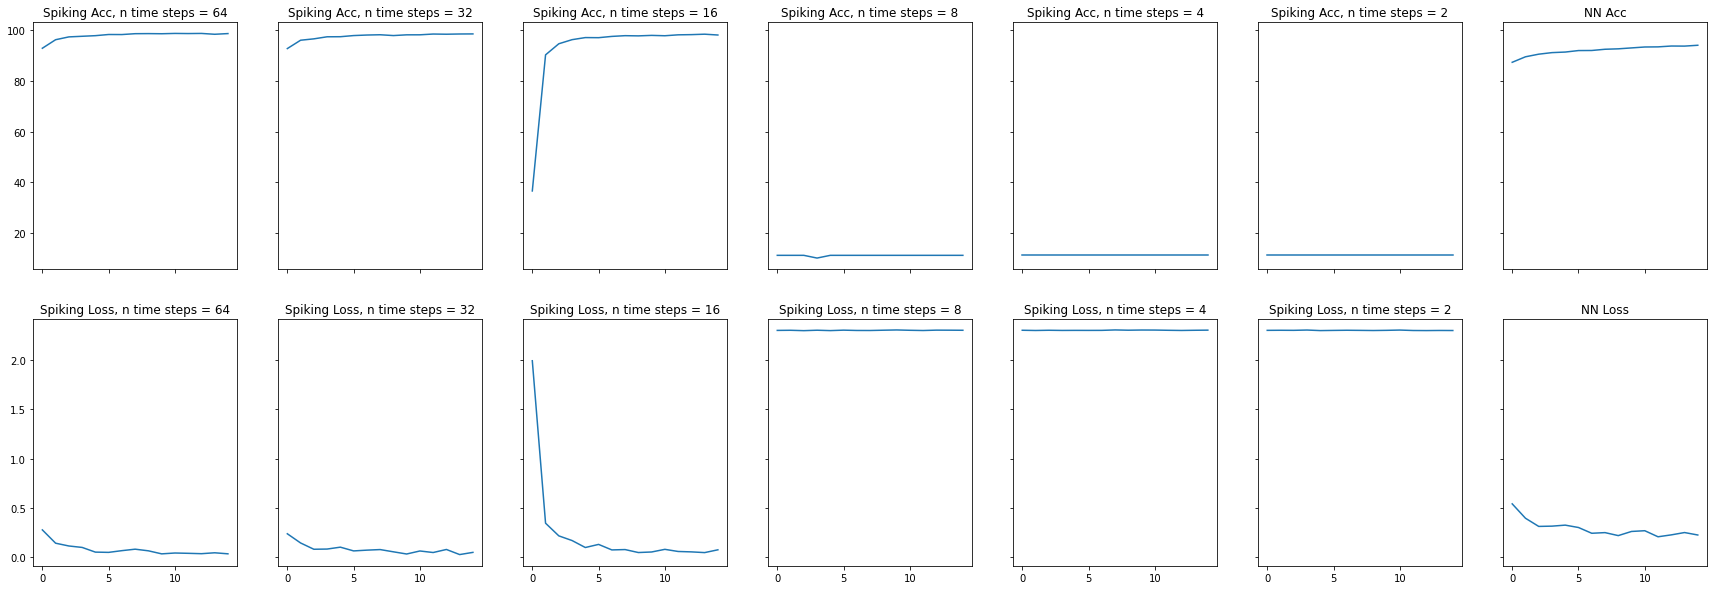

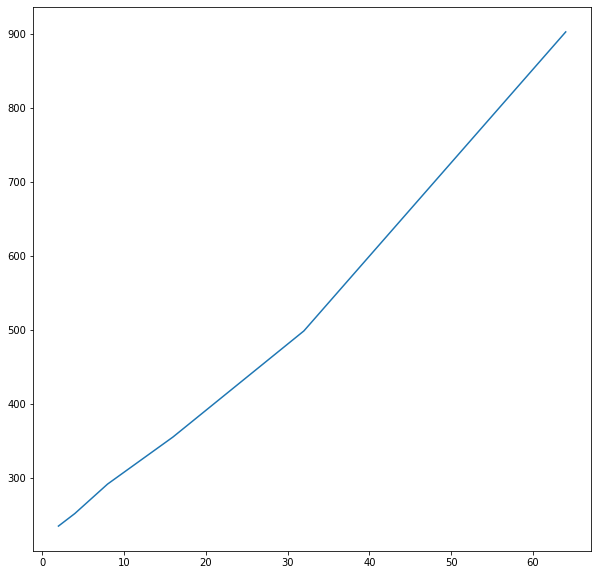

In [76]:
###############################################################################
        
num_epoch = 15

time_step_list = [128/2,128/4,128/8,128/16,128/32,128/64]
total_time_models = []

fig, ax_lst = plt.subplots(2, len(time_step_list)+1, sharex=True, sharey='row',figsize=(30,10))

for i,step in enumerate(time_step_list):      
  spiking_model = SpikingConvNet(device, n_time_steps=int(step), begin_eval=0)
  loss, acc, time_m = train_many_epochs(spiking_model, epochs = num_epoch)
  total_time_models.append(time_m)
  ax_lst[0,i].plot(acc)
  ax_lst[0,i].set_title("Spiking Acc, n time steps = %d"%int(step))
  ax_lst[1,i].plot(loss)
  ax_lst[1,i].set_title("Spiking Loss, n time steps = %d"%int(step))

non_spiking_model = NonSpikingNet().to(device)
loss, acc, time_m = train_many_epochs(non_spiking_model, epochs = num_epoch)
ax_lst[0,len(time_step_list)].plot(acc)
ax_lst[0,len(time_step_list)].set_title("NN Acc")
ax_lst[1,len(time_step_list)].plot(loss)
ax_lst[1,len(time_step_list)].set_title("NN Loss")
plt.show()

plt.figure(figsize=(10,10))
plt.plot(time_step_list, total_time_models)
plt.show()


In [2]:
#Imports
import os
import matplotlib.pyplot as plt
import torchvision.datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.autograd import Variable


###############################################################################

def train(model, device, train_set_loader, optimizer, epoch, logging_interval=1000):
    # This method is derived from: 
    # https://github.com/pytorch/examples/blob/master/mnist/main.py
    # Was licensed BSD-3-clause
    
    model.train()
    for batch_idx, (data, target) in enumerate(train_set_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % logging_interval == 0:
            pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct = pred.eq(target.view_as(pred)).float().mean().item()
            print('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f} Accuracy: {:.2f}%'.format(
                epoch, batch_idx * len(data), len(train_set_loader.dataset),
                100. * batch_idx / len(train_set_loader), loss.item(),
                100. * correct))
            
    return loss.item()

import time
def train_many_epochs(model, epochs = 10): 
    lr = 0.1
    start = time.time()
    loss_ot = []
    acc_ot = []
    for epoch in range(epochs):
      optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.7)
      loss = train(model, device, train_set_loader, optimizer, epoch, logging_interval=1000)
      acc = test(model, device, test_set_loader)
      loss_ot.append(loss)
      acc_ot.append(acc)
      lr = lr/2.0
    end = time.time()
    total_time = end - start
    print(total_time)
    return loss_ot, acc_ot, total_time

def test(model, device, test_set_loader):
    # This method is derived from: 
    # https://github.com/pytorch/examples/blob/master/mnist/main.py
    # Was licensed BSD-3-clause
    
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_set_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # Note: with `reduce=True`, I'm not sure what would happen with a final batch size 
            # that would be smaller than regular previous batch sizes. For now it works.
            test_loss += F.nll_loss(output, target, reduce=True).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_set_loader.dataset)
    print("")
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss, 
        correct, len(test_set_loader.dataset),
        100. * correct / len(test_set_loader.dataset)))
    print("")
    return 100. * correct / len(test_set_loader.dataset)

def download_mnist(data_path):
    if not os.path.exists(data_path):
        os.mkdir(data_path)
    transformation = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
    training_set = torchvision.datasets.MNIST(data_path, train=True, transform=transformation, download=True)
    testing_set = torchvision.datasets.MNIST(data_path, train=False, transform=transformation, download=True)
    return training_set, testing_set

###############################################################################

batch_size = 32
DATA_PATH = './data'

training_set, testing_set = download_mnist(DATA_PATH)
train_set_loader = torch.utils.data.DataLoader(
    dataset=training_set,
    batch_size=batch_size,
    shuffle=True)
test_set_loader = torch.utils.data.DataLoader(
    dataset=testing_set,
    batch_size=batch_size,
    shuffle=False)

###############################################################################

# Use GPU whever possible!
import torch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

###############################################################################

class SpikingNeuronLayerRNN(nn.Module):
    
    def __init__(self, device, n_inputs=28*28, n_hidden=100, decay_multiplier=0.9, threshold=2.0, penalty_threshold=2.5):
        super(SpikingNeuronLayerRNN, self).__init__()
        self.device = device
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.decay_multiplier = decay_multiplier
        self.threshold = threshold
        self.penalty_threshold = penalty_threshold
        
        self.fc = nn.Linear(n_inputs, n_hidden)
        
        self.init_parameters()
        self.reset_state()
        self.to(self.device)
        
    def init_parameters(self):
        for param in self.parameters():
            if param.dim() >= 2:
                nn.init.xavier_uniform_(param)
        
    def reset_state(self):
        self.prev_inner = torch.zeros([self.n_hidden]).to(self.device)
        self.prev_outer = torch.zeros([self.n_hidden]).to(self.device)

    def forward(self, x):
        """
        Call the neuron at every time step.
        
        x: activated_neurons_below
        
        return: a tuple of (state, output) for each time step. Each item in the tuple
        are then themselves of shape (batch_size, n_hidden) and are PyTorch objects, such 
        that the whole returned would be of shape (2, batch_size, n_hidden) if casted.
        """
        if self.prev_inner.dim() == 1:
            # Adding batch_size dimension directly after doing a `self.reset_state()`:
            batch_size = x.shape[0]
            self.prev_inner = torch.stack(batch_size * [self.prev_inner])
            self.prev_outer = torch.stack(batch_size * [self.prev_outer])
        
        # 1. Weight matrix multiplies the input x
        input_excitation = self.fc(x)
        
        # 2. We add the result to a decayed version of the information we already had.
        inner_excitation = input_excitation + self.prev_inner * self.decay_multiplier
        
        # 3. We compute the activation of the neuron to find its output value, 
        #    but before the activation, there is also a negative bias that refrain thing from firing too much.
        outer_excitation = F.relu(inner_excitation - self.threshold)
        
        # 4. If the neuron fires, the activation of the neuron is subtracted to its inner state 
        #    (and with an extra penalty for increase refractory time), 
        #    because it discharges naturally so it shouldn't fire twice. 
        do_penalize_gate = (outer_excitation > 0).float()
        # TODO: remove following /2?
        inner_excitation = inner_excitation - (self.penalty_threshold/self.threshold * inner_excitation) * do_penalize_gate
        
        # 5. The outer excitation has a negative part after the positive part. 
        outer_excitation = outer_excitation #+ torch.abs(self.prev_outer) * self.decay_multiplier / 2.0
        
        # 6. Setting internal values before returning. 
        #    And the returning value is the one of the previous time step to delay 
        #    activation of 1 time step of "processing" time. For logits, we don't take activation.
        delayed_return_state = self.prev_inner
        delayed_return_output = self.prev_outer
        self.prev_inner = inner_excitation
        self.prev_outer = outer_excitation
        return delayed_return_state, delayed_return_output
    

###############################################################################

class SpikingNeuronLayerCRNN(nn.Module):
    
    def __init__(self, device, n_hidden=64, decay_multiplier=0.9, threshold=2.0, penalty_threshold=2.5):
        super(SpikingNeuronLayerCRNN, self).__init__()
        self.device = device
        self.n_hidden = n_hidden
        self.decay_multiplier = decay_multiplier
        self.threshold = threshold
        self.penalty_threshold = penalty_threshold
        
        self.conv = torch.nn.Sequential(
                              nn.Conv2d(1, 6, 5),
                              nn.ReLU(),
                              nn.MaxPool2d(2, 2),
                              nn.Conv2d(6, 12, 5),
                              nn.ReLU(),
        )
        self.fc = torch.nn.Sequential(
                              nn.Linear(12 * 8 * 8, 100),
                              nn.ReLU()
        )
                        
        self.init_parameters()
        self.reset_state()
        self.to(self.device)
        
    def init_parameters(self):
        for param in self.parameters():
            if param.dim() >= 2:
                nn.init.xavier_uniform_(param)
        
    def reset_state(self):
        self.prev_inner = torch.zeros([self.n_hidden]).to(self.device)
        self.prev_outer = torch.zeros([self.n_hidden]).to(self.device)

    def forward(self, x):
        """
        Call the neuron at every time step.
        
        x: activated_neurons_below
        
        return: a tuple of (state, output) for each time step. Each item in the tuple
        are then themselves of shape (batch_size, n_hidden) and are PyTorch objects, such 
        that the whole returned would be of shape (2, batch_size, n_hidden) if casted.
        """
        if self.prev_inner.dim() == 1:
            # Adding batch_size dimension directly after doing a `self.reset_state()`:
            batch_size = x.shape[0]
            self.prev_inner = torch.stack(batch_size * [self.prev_inner])
            self.prev_outer = torch.stack(batch_size * [self.prev_outer])
        
        # 1. Weight matrix multiplies the input x
        conv_excitation = self.conv(x)
        conv_excitation = conv_excitation.view(-1, 12 * 8 * 8)
        input_excitation = self.fc(conv_excitation)
        
        # 2. We add the result to a decayed version of the information we already had.
        inner_excitation = input_excitation + self.prev_inner * self.decay_multiplier
        
        # 3. We compute the activation of the neuron to find its output value, 
        #    but before the activation, there is also a negative bias that refrain thing from firing too much.
        outer_excitation = F.relu(inner_excitation - self.threshold)
        
        # 4. If the neuron fires, the activation of the neuron is subtracted to its inner state 
        #    (and with an extra penalty for increase refractory time), 
        #    because it discharges naturally so it shouldn't fire twice. 
        do_penalize_gate = (outer_excitation > 0).float()
        # TODO: remove following /2?
        inner_excitation = inner_excitation - (self.penalty_threshold/self.threshold * inner_excitation) * do_penalize_gate
        
        # 5. The outer excitation has a negative part after the positive part. 
        outer_excitation = outer_excitation #+ torch.abs(self.prev_outer) * self.decay_multiplier / 2.0
        
        # 6. Setting internal values before returning. 
        #    And the returning value is the one of the previous time step to delay 
        #    activation of 1 time step of "processing" time. For logits, we don't take activation.
        delayed_return_state = self.prev_inner
        delayed_return_output = self.prev_outer
        self.prev_inner = inner_excitation
        self.prev_outer = outer_excitation
        return delayed_return_state, delayed_return_output
    
###############################################################################
        
class InputDataToSpikingPerceptronLayer(nn.Module):
    
    def __init__(self, device):
        super(InputDataToSpikingPerceptronLayer, self).__init__()
        self.device = device
        
        self.reset_state()
        self.to(self.device)
        
    def reset_state(self):
        #     self.prev_state = torch.zeros([self.n_hidden]).to(self.device)
        pass
    
    def forward(self, x, is_2D=True):
        #x = x.view(x.size(0), -1)  # Flatten 2D image to 1D for FC
        random_activation_perceptron = torch.rand(x.shape).to(self.device)
        return random_activation_perceptron * x
    
###############################################################################

class OutputDataToSpikingPerceptronLayer(nn.Module):
    
    def __init__(self, average_output=True):
        """
        average_output: might be needed if this is used within a regular neural net as a layer.
        Otherwise, sum may be numerically more stable for gradients with setting average_output=False.
        """
        super(OutputDataToSpikingPerceptronLayer, self).__init__()
        if average_output:
            self.reducer = lambda x, dim: x.sum(dim=dim)
        else:
            self.reducer = lambda x, dim: x.mean(dim=dim)
    
    def forward(self, x):
        if type(x) == list:
            x = torch.stack(x)
        return self.reducer(x, 0)
    
###############################################################################
        
class SpikingConvNet(nn.Module):
    
    def __init__(self, device, n_time_steps, begin_eval):
        super(SpikingConvNet, self).__init__()
        assert (0 <= begin_eval and begin_eval < n_time_steps)
        self.device = device
        self.n_time_steps = n_time_steps
        self.begin_eval = begin_eval
        
        self.input_conversion = InputDataToSpikingPerceptronLayer(device)
        
        self.layer1 = SpikingNeuronLayerCRNN(
            device, n_hidden=100,
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
        
        self.layer2 = SpikingNeuronLayerRNN(
            device, n_inputs=100, n_hidden=10,
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
        
        self.output_conversion = OutputDataToSpikingPerceptronLayer(average_output=False)  # Sum on outputs.
        
        self.to(self.device)
    
    def forward_through_time(self, x):
        """
        This acts as a layer. Its input is non-time-related, and its output too.
        So the time iterations happens inside, and the returned layer is thus
        passed through global average pooling on the time axis before the return 
        such as to be able to mix this pipeline with regular backprop layers such
        as the input data and the output data.
        """
        self.input_conversion.reset_state()
        self.layer1.reset_state()
        self.layer2.reset_state()

        out = []
        
        all_layer1_states = []
        all_layer1_outputs = []
        all_layer2_states = []
        all_layer2_outputs = []
        for _ in range(self.n_time_steps):
            xi = self.input_conversion(x)
            
            # For layer 1, we take the regular output.
            layer1_state, layer1_output = self.layer1(xi)
            
            # We take inner state of layer 2 because it's pre-activation and thus acts as out logits.
            layer2_state, layer2_output = self.layer2(layer1_output)
            
            all_layer1_states.append(layer1_state)
            all_layer1_outputs.append(layer1_output)
            all_layer2_states.append(layer2_state)
            all_layer2_outputs.append(layer2_output)
            out.append(layer2_state)
            
        out = self.output_conversion(out[self.begin_eval:])
        return out, [[all_layer1_states, all_layer1_outputs], [all_layer2_states, all_layer2_outputs]]
    
    def forward(self, x):
        out, _ = self.forward_through_time(x)
        return F.log_softmax(out, dim=-1)

    def visualize_all_neurons(self, x):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to SpikingNet.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        for i, (all_layer_states, all_layer_outputs) in enumerate(layers_state):
            layer_state  =  torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
            layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()
            
            self.plot_layer(layer_state, title="Inner state values of neurons for layer {}".format(i))
            self.plot_layer(layer_output, title="Output spikes (activation) values of neurons for layer {}".format(i))
    
    def visualize_neuron(self, x, layer_idx, neuron_idx):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to SpikingNet.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        all_layer_states, all_layer_outputs = layers_state[layer_idx]
        layer_state  =  torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
        layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()

        self.plot_neuron(layer_state[neuron_idx], title="Inner state values neuron {} of layer {}".format(neuron_idx, layer_idx))
        self.plot_neuron(layer_output[neuron_idx], title="Output spikes (activation) values of neuron {} of layer {}".format(neuron_idx, layer_idx))

    def plot_layer(self, layer_values, title):
        """
        This function is derived from: 
            https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition 
        Which was released under the MIT License. 
        """
        width = max(16, layer_values.shape[0] / 8)
        height = max(4, layer_values.shape[1] / 8)
        plt.figure(figsize=(width, height))
        plt.imshow(
            layer_values,
            interpolation="nearest",
            cmap=plt.cm.rainbow
        )
        plt.title(title)
        plt.colorbar()
        plt.xlabel("Time")
        plt.ylabel("Neurons of layer")
        plt.show()

    def plot_neuron(self, neuron_through_time, title):
        width = max(16, len(neuron_through_time) / 8)
        height = 4
        plt.figure(figsize=(width, height))
        plt.title(title)
        plt.plot(neuron_through_time)
        plt.xlabel("Time")
        plt.ylabel("Neuron's activation")
        plt.show()

###############################################################################


class NonSpikingNet(nn.Module):
    
    def __init__(self):
        super(NonSpikingNet, self).__init__()
        self.layer1 = nn.Linear(1* 28* 28, 100)
        self.layer2 = nn.Linear(100, 10)

    def forward(self, x, is_2D=True):
        x = x.view(x.size(0), -1)  # Flatten 2D image to 1D for FC
        x = F.relu(self.layer1(x))
        x =        self.layer2(x)
        return F.log_softmax(x, dim=-1)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
###############################################################################
        
num_epoch = 15

time_step_list = [128/1,128/2]
total_time_models = []

fig, ax_lst = plt.subplots(2, len(time_step_list)+1, sharex=True, sharey='row',figsize=(30,10))

for i,step in enumerate(time_step_list):      
  spiking_model = SpikingConvNet(device, n_time_steps=int(step), begin_eval=0)
  loss, acc, time_m = train_many_epochs(spiking_model, epochs = num_epoch)
  total_time_models.append(time_m)
  ax_lst[0,i].plot(acc)
  ax_lst[0,i].set_title("Spiking Acc, n time steps = %d"%int(step))
  ax_lst[1,i].plot(loss)
  ax_lst[1,i].set_title("Spiking Loss, n time steps = %d"%int(step))



Train Epoch: 0 [0/60000 (0%)] Loss: 2.533815 Accuracy: 3.12%
Train Epoch: 0 [32000/60000 (53%)] Loss: 0.108673 Accuracy: 96.88%


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0025, Accuracy: 9753/10000 (97.53%)

Train Epoch: 1 [0/60000 (0%)] Loss: 0.028188 Accuracy: 100.00%
Train Epoch: 1 [32000/60000 (53%)] Loss: 0.018620 Accuracy: 100.00%

Test set: Average loss: 0.0017, Accuracy: 9841/10000 (98.41%)

Train Epoch: 2 [0/60000 (0%)] Loss: 0.016472 Accuracy: 100.00%
Train Epoch: 2 [32000/60000 (53%)] Loss: 0.013687 Accuracy: 100.00%

Test set: Average loss: 0.0018, Accuracy: 9828/10000 (98.28%)

Train Epoch: 3 [0/60000 (0%)] Loss: 0.008146 Accuracy: 100.00%
Train Epoch: 3 [32000/60000 (53%)] Loss: 0.004066 Accuracy: 100.00%

Test set: Average loss: 0.0016, Accuracy: 9839/10000 (98.39%)

Train Epoch: 4 [0/60000 (0%)] Loss: 0.013303 Accuracy: 100.00%
Train Epoch: 4 [32000/60000 (53%)] Loss: 0.009713 Accuracy: 100.00%

Test set: Average loss: 0.0012, Accuracy: 9878/10000 (98.78%)

Train Epoch: 5 [0/60000 (0%)] Loss: 0.000265 Accuracy: 100.00%
Train Epoch: 5 [32000/60000 (53%)] Loss: 0.137562 Accuracy: 96.88%

Test set: Average loss: 0

Colab killed my above code :(





Train Epoch: 0 [0/60000 (0%)] Loss: 2.387563 Accuracy: 9.38%
Train Epoch: 0 [32000/60000 (53%)] Loss: 0.122512 Accuracy: 93.75%


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0025, Accuracy: 9733/10000 (97.33%)

Train Epoch: 1 [0/60000 (0%)] Loss: 0.031165 Accuracy: 96.88%
Train Epoch: 1 [32000/60000 (53%)] Loss: 0.138768 Accuracy: 96.88%

Test set: Average loss: 0.0017, Accuracy: 9823/10000 (98.23%)

Train Epoch: 2 [0/60000 (0%)] Loss: 0.056247 Accuracy: 96.88%
Train Epoch: 2 [32000/60000 (53%)] Loss: 0.004320 Accuracy: 100.00%

Test set: Average loss: 0.0017, Accuracy: 9837/10000 (98.37%)

Train Epoch: 3 [0/60000 (0%)] Loss: 0.137876 Accuracy: 96.88%
Train Epoch: 3 [32000/60000 (53%)] Loss: 0.023337 Accuracy: 96.88%

Test set: Average loss: 0.0020, Accuracy: 9801/10000 (98.01%)

Train Epoch: 4 [0/60000 (0%)] Loss: 0.070160 Accuracy: 96.88%
Train Epoch: 4 [32000/60000 (53%)] Loss: 0.003842 Accuracy: 100.00%

Test set: Average loss: 0.0016, Accuracy: 9839/10000 (98.39%)

Train Epoch: 5 [0/60000 (0%)] Loss: 0.076192 Accuracy: 96.88%
Train Epoch: 5 [32000/60000 (53%)] Loss: 0.007170 Accuracy: 100.00%

Test set: Average loss: 0.0014,

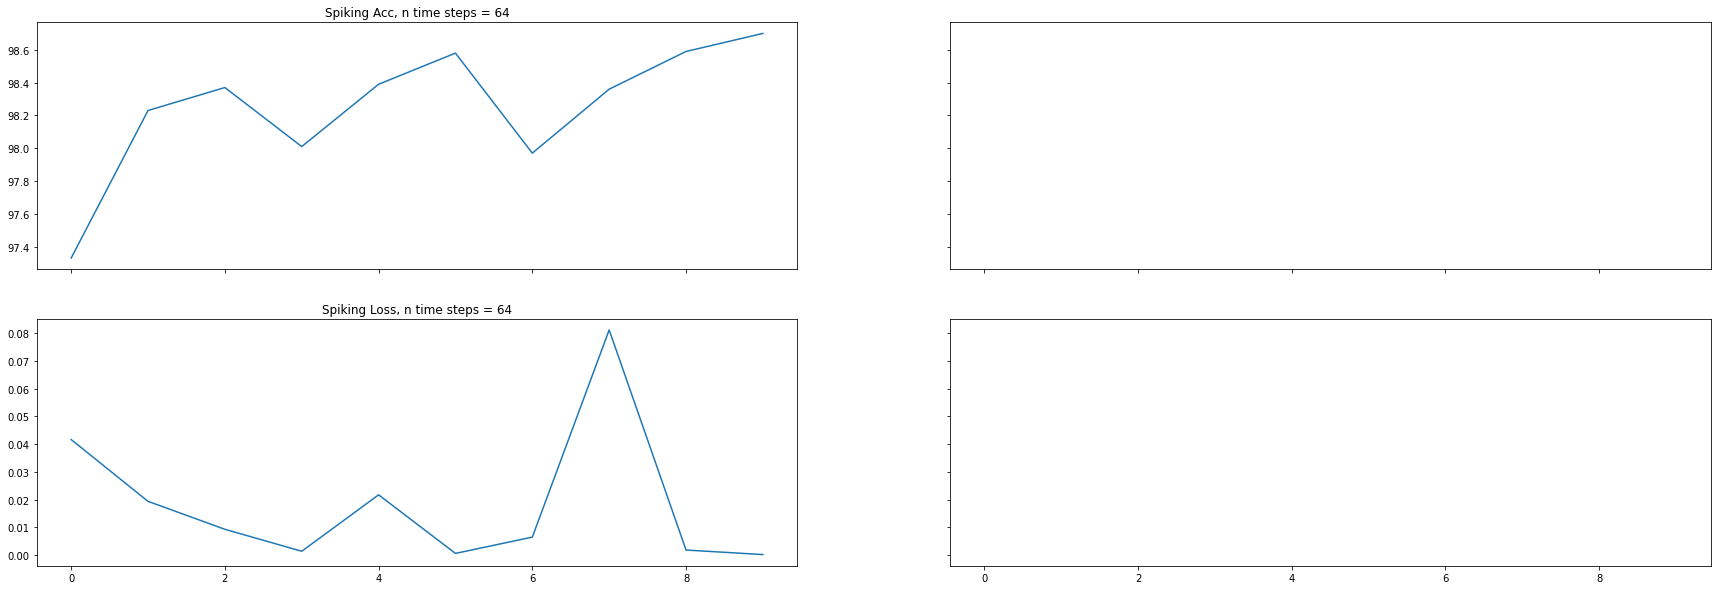

In [3]:
###############################################################################
        
num_epoch = 10

time_step_list = [128/2]
total_time_models = []

fig, ax_lst = plt.subplots(2, len(time_step_list)+1, sharex=True, sharey='row',figsize=(30,10))

for i,step in enumerate(time_step_list):      
  spiking_model = SpikingConvNet(device, n_time_steps=int(step), begin_eval=0)
  loss, acc, time_m = train_many_epochs(spiking_model, epochs = num_epoch)
  total_time_models.append(time_m)
  ax_lst[0,i].plot(acc)
  ax_lst[0,i].set_title("Spiking Acc, n time steps = %d"%int(step))
  ax_lst[1,i].plot(loss)
  ax_lst[1,i].set_title("Spiking Loss, n time steps = %d"%int(step))


In [0]:
#Imports
import os
import matplotlib.pyplot as plt
import torchvision.datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.autograd import Variable


###############################################################################

def train(model, device, train_set_loader, optimizer, epoch, logging_interval=1000):
    # This method is derived from: 
    # https://github.com/pytorch/examples/blob/master/mnist/main.py
    # Was licensed BSD-3-clause
    
    model.train()
    for batch_idx, (data, target) in enumerate(train_set_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % logging_interval == 0:
            pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct = pred.eq(target.view_as(pred)).float().mean().item()
            print('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f} Accuracy: {:.2f}%'.format(
                epoch, batch_idx * len(data), len(train_set_loader.dataset),
                100. * batch_idx / len(train_set_loader), loss.item(),
                100. * correct))
            
    return loss.item()

import time
def train_many_epochs(model, epochs = 10): 
    lr = 0.1
    start = time.time()
    loss_ot = []
    acc_ot = []
    for epoch in range(epochs):
      optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9)
      loss = train(model, device, train_set_loader, optimizer, epoch, logging_interval=1000)
      acc = test(model, device, test_set_loader)
      loss_ot.append(loss)
      acc_ot.append(acc)
      lr = lr/2.0
    end = time.time()
    total_time = end - start
    print(total_time)
    return loss_ot, acc_ot, total_time

def test(model, device, test_set_loader):
    # This method is derived from: 
    # https://github.com/pytorch/examples/blob/master/mnist/main.py
    # Was licensed BSD-3-clause
    
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_set_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # Note: with `reduce=True`, I'm not sure what would happen with a final batch size 
            # that would be smaller than regular previous batch sizes. For now it works.
            test_loss += F.nll_loss(output, target, reduce=True).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_set_loader.dataset)
    print("")
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss, 
        correct, len(test_set_loader.dataset),
        100. * correct / len(test_set_loader.dataset)))
    print("")
    return 100. * correct / len(test_set_loader.dataset)

def download_mnist(data_path):
    if not os.path.exists(data_path):
        os.mkdir(data_path)
    transformation = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
    training_set = torchvision.datasets.MNIST(data_path, train=True, transform=transformation, download=True)
    testing_set = torchvision.datasets.MNIST(data_path, train=False, transform=transformation, download=True)
    return training_set, testing_set

###############################################################################

batch_size = 32
DATA_PATH = './data'

training_set, testing_set = download_mnist(DATA_PATH)
train_set_loader = torch.utils.data.DataLoader(
    dataset=training_set,
    batch_size=batch_size,
    shuffle=True)
test_set_loader = torch.utils.data.DataLoader(
    dataset=testing_set,
    batch_size=batch_size,
    shuffle=False)

###############################################################################

# Use GPU whever possible!
import torch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

###############################################################################

class SpikingNeuronLayerRNN(nn.Module):
    
    def __init__(self, device, n_inputs=28*28, n_hidden=100, decay_multiplier=0.9, threshold=2.0, penalty_threshold=2.5):
        super(SpikingNeuronLayerRNN, self).__init__()
        self.device = device
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.decay_multiplier = decay_multiplier
        self.threshold = threshold
        self.penalty_threshold = penalty_threshold
        
        self.fc = nn.Linear(n_inputs, n_hidden)
        
        self.init_parameters()
        self.reset_state()
        self.to(self.device)
        
    def init_parameters(self):
        for param in self.parameters():
            if param.dim() >= 2:
                nn.init.xavier_uniform_(param)
        
    def reset_state(self):
        self.prev_inner = torch.zeros([self.n_hidden]).to(self.device)
        self.prev_outer = torch.zeros([self.n_hidden]).to(self.device)

    def forward(self, x):
        """
        Call the neuron at every time step.
        
        x: activated_neurons_below
        
        return: a tuple of (state, output) for each time step. Each item in the tuple
        are then themselves of shape (batch_size, n_hidden) and are PyTorch objects, such 
        that the whole returned would be of shape (2, batch_size, n_hidden) if casted.
        """
        if self.prev_inner.dim() == 1:
            # Adding batch_size dimension directly after doing a `self.reset_state()`:
            batch_size = x.shape[0]
            self.prev_inner = torch.stack(batch_size * [self.prev_inner])
            self.prev_outer = torch.stack(batch_size * [self.prev_outer])
        
        # 1. Weight matrix multiplies the input x
        input_excitation = self.fc(x)
        
        # 2. We add the result to a decayed version of the information we already had.
        inner_excitation = input_excitation + self.prev_inner * self.decay_multiplier
        
        # 3. We compute the activation of the neuron to find its output value, 
        #    but before the activation, there is also a negative bias that refrain thing from firing too much.
        outer_excitation = F.relu(inner_excitation - self.threshold)
        
        # 4. If the neuron fires, the activation of the neuron is subtracted to its inner state 
        #    (and with an extra penalty for increase refractory time), 
        #    because it discharges naturally so it shouldn't fire twice. 
        do_penalize_gate = (outer_excitation > 0).float()
        # TODO: remove following /2?
        inner_excitation = inner_excitation - (self.penalty_threshold/self.threshold * inner_excitation) * do_penalize_gate
        
        # 5. The outer excitation has a negative part after the positive part. 
        outer_excitation = outer_excitation #+ torch.abs(self.prev_outer) * self.decay_multiplier / 2.0
        
        # 6. Setting internal values before returning. 
        #    And the returning value is the one of the previous time step to delay 
        #    activation of 1 time step of "processing" time. For logits, we don't take activation.
        delayed_return_state = self.prev_inner
        delayed_return_output = self.prev_outer
        self.prev_inner = inner_excitation
        self.prev_outer = outer_excitation
        return delayed_return_state, delayed_return_output
    

###############################################################################

class SpikingNeuronLayerCRNN(nn.Module):
    
    def __init__(self, device, n_hidden=64, decay_multiplier=0.9, threshold=2.0, penalty_threshold=2.5):
        super(SpikingNeuronLayerCRNN, self).__init__()
        self.device = device
        self.n_hidden = n_hidden
        self.decay_multiplier = decay_multiplier
        self.threshold = threshold
        self.penalty_threshold = penalty_threshold
        
        self.conv = torch.nn.Sequential(
                              nn.Conv2d(1, 6, 5),
                              nn.ReLU(),
                              nn.MaxPool2d(2, 2),
                              nn.Conv2d(6, 12, 5),
                              nn.ReLU(),
        )
        self.fc = torch.nn.Sequential(
                              nn.Linear(12 * 8 * 8, 100),
                              nn.ReLU()
        )
                        
        self.init_parameters()
        self.reset_state()
        self.to(self.device)
        
    def init_parameters(self):
        for param in self.parameters():
            if param.dim() >= 2:
                nn.init.xavier_uniform_(param)
        
    def reset_state(self):
        self.prev_inner = torch.zeros([self.n_hidden]).to(self.device)
        self.prev_outer = torch.zeros([self.n_hidden]).to(self.device)

    def forward(self, x):
        """
        Call the neuron at every time step.
        
        x: activated_neurons_below
        
        return: a tuple of (state, output) for each time step. Each item in the tuple
        are then themselves of shape (batch_size, n_hidden) and are PyTorch objects, such 
        that the whole returned would be of shape (2, batch_size, n_hidden) if casted.
        """
        if self.prev_inner.dim() == 1:
            # Adding batch_size dimension directly after doing a `self.reset_state()`:
            batch_size = x.shape[0]
            self.prev_inner = torch.stack(batch_size * [self.prev_inner])
            self.prev_outer = torch.stack(batch_size * [self.prev_outer])
        
        # 1. Weight matrix multiplies the input x
        conv_excitation = self.conv(x)
        conv_excitation = conv_excitation.view(-1, 12 * 8 * 8)
        input_excitation = self.fc(conv_excitation)
        
        # 2. We add the result to a decayed version of the information we already had.
        inner_excitation = input_excitation + self.prev_inner * self.decay_multiplier
        
        # 3. We compute the activation of the neuron to find its output value, 
        #    but before the activation, there is also a negative bias that refrain thing from firing too much.
        outer_excitation = F.relu(inner_excitation - self.threshold)
        
        # 4. If the neuron fires, the activation of the neuron is subtracted to its inner state 
        #    (and with an extra penalty for increase refractory time), 
        #    because it discharges naturally so it shouldn't fire twice. 
        do_penalize_gate = (outer_excitation > 0).float()
        # TODO: remove following /2?
        inner_excitation = inner_excitation - (self.penalty_threshold/self.threshold * inner_excitation) * do_penalize_gate
        
        # 5. The outer excitation has a negative part after the positive part. 
        outer_excitation = outer_excitation #+ torch.abs(self.prev_outer) * self.decay_multiplier / 2.0
        
        # 6. Setting internal values before returning. 
        #    And the returning value is the one of the previous time step to delay 
        #    activation of 1 time step of "processing" time. For logits, we don't take activation.
        delayed_return_state = self.prev_inner
        delayed_return_output = self.prev_outer
        self.prev_inner = inner_excitation
        self.prev_outer = outer_excitation
        return delayed_return_state, delayed_return_output
    
###############################################################################
        
class InputDataToSpikingPerceptronLayer(nn.Module):
    
    def __init__(self, device):
        super(InputDataToSpikingPerceptronLayer, self).__init__()
        self.device = device
        
        self.reset_state()
        self.to(self.device)
        
    def reset_state(self):
        #     self.prev_state = torch.zeros([self.n_hidden]).to(self.device)
        pass
    
    def forward(self, x, is_2D=True):
        #x = x.view(x.size(0), -1)  # Flatten 2D image to 1D for FC
        random_activation_perceptron = torch.rand(x.shape).to(self.device)
        return random_activation_perceptron * x
    
###############################################################################

class OutputDataToSpikingPerceptronLayer(nn.Module):
    
    def __init__(self, average_output=True):
        """
        average_output: might be needed if this is used within a regular neural net as a layer.
        Otherwise, sum may be numerically more stable for gradients with setting average_output=False.
        """
        super(OutputDataToSpikingPerceptronLayer, self).__init__()
        if average_output:
            self.reducer = lambda x, dim: x.sum(dim=dim)
        else:
            self.reducer = lambda x, dim: x.mean(dim=dim)
    
    def forward(self, x):
        if type(x) == list:
            x = torch.stack(x)
        return self.reducer(x, 0)
    
###############################################################################
        
class SpikingConvNet(nn.Module):
    
    def __init__(self, device, n_time_steps, begin_eval):
        super(SpikingConvNet, self).__init__()
        assert (0 <= begin_eval and begin_eval < n_time_steps)
        self.device = device
        self.n_time_steps = n_time_steps
        self.begin_eval = begin_eval
        
        self.input_conversion = InputDataToSpikingPerceptronLayer(device)
        
        self.layer1 = SpikingNeuronLayerCRNN(
            device, n_hidden=100,
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
        
        self.layer2 = SpikingNeuronLayerRNN(
            device, n_inputs=100, n_hidden=10,
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
        
        self.output_conversion = OutputDataToSpikingPerceptronLayer(average_output=False)  # Sum on outputs.
        
        self.to(self.device)
    
    def forward_through_time(self, x):
        """
        This acts as a layer. Its input is non-time-related, and its output too.
        So the time iterations happens inside, and the returned layer is thus
        passed through global average pooling on the time axis before the return 
        such as to be able to mix this pipeline with regular backprop layers such
        as the input data and the output data.
        """
        self.input_conversion.reset_state()
        self.layer1.reset_state()
        self.layer2.reset_state()

        out = []
        
        all_layer1_states = []
        all_layer1_outputs = []
        all_layer2_states = []
        all_layer2_outputs = []
        for _ in range(self.n_time_steps):
            xi = self.input_conversion(x)
            
            # For layer 1, we take the regular output.
            layer1_state, layer1_output = self.layer1(xi)
            
            # We take inner state of layer 2 because it's pre-activation and thus acts as out logits.
            layer2_state, layer2_output = self.layer2(layer1_output)
            
            all_layer1_states.append(layer1_state)
            all_layer1_outputs.append(layer1_output)
            all_layer2_states.append(layer2_state)
            all_layer2_outputs.append(layer2_output)
            out.append(layer2_state)
            
        out = self.output_conversion(out[self.begin_eval:])
        return out, [[all_layer1_states, all_layer1_outputs], [all_layer2_states, all_layer2_outputs]]
    
    def forward(self, x):
        out, _ = self.forward_through_time(x)
        return F.log_softmax(out, dim=-1)

    def visualize_all_neurons(self, x):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to SpikingNet.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        for i, (all_layer_states, all_layer_outputs) in enumerate(layers_state):
            layer_state  =  torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
            layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()
            
            self.plot_layer(layer_state, title="Inner state values of neurons for layer {}".format(i))
            self.plot_layer(layer_output, title="Output spikes (activation) values of neurons for layer {}".format(i))
    
    def visualize_neuron(self, x, layer_idx, neuron_idx):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to SpikingNet.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        all_layer_states, all_layer_outputs = layers_state[layer_idx]
        layer_state  =  torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
        layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()

        self.plot_neuron(layer_state[neuron_idx], title="Inner state values neuron {} of layer {}".format(neuron_idx, layer_idx))
        self.plot_neuron(layer_output[neuron_idx], title="Output spikes (activation) values of neuron {} of layer {}".format(neuron_idx, layer_idx))

    def plot_layer(self, layer_values, title):
        """
        This function is derived from: 
            https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition 
        Which was released under the MIT License. 
        """
        width = max(16, layer_values.shape[0] / 8)
        height = max(4, layer_values.shape[1] / 8)
        plt.figure(figsize=(width, height))
        plt.imshow(
            layer_values,
            interpolation="nearest",
            cmap=plt.cm.rainbow
        )
        plt.title(title)
        plt.colorbar()
        plt.xlabel("Time")
        plt.ylabel("Neurons of layer")
        plt.show()

    def plot_neuron(self, neuron_through_time, title):
        width = max(16, len(neuron_through_time) / 8)
        height = 4
        plt.figure(figsize=(width, height))
        plt.title(title)
        plt.plot(neuron_through_time)
        plt.xlabel("Time")
        plt.ylabel("Neuron's activation")
        plt.show()

###############################################################################


class NonSpikingNet(nn.Module):
    
    def __init__(self):
        super(NonSpikingNet, self).__init__()
        self.layer1 = nn.Linear(1* 28* 28, 100)
        self.layer2 = nn.Linear(100, 10)

    def forward(self, x, is_2D=True):
        x = x.view(x.size(0), -1)  # Flatten 2D image to 1D for FC
        x = F.relu(self.layer1(x))
        x =        self.layer2(x)
        return F.log_softmax(x, dim=-1)

Train Epoch: 0 [0/60000 (0%)] Loss: 2.447953 Accuracy: 3.12%
Train Epoch: 0 [32000/60000 (53%)] Loss: 0.159183 Accuracy: 96.88%


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0034, Accuracy: 9711/10000 (97.11%)

Train Epoch: 1 [0/60000 (0%)] Loss: 0.830067 Accuracy: 90.62%
Train Epoch: 1 [32000/60000 (53%)] Loss: 0.038864 Accuracy: 96.88%

Test set: Average loss: 0.0027, Accuracy: 9742/10000 (97.42%)

Train Epoch: 2 [0/60000 (0%)] Loss: 0.047920 Accuracy: 100.00%
Train Epoch: 2 [32000/60000 (53%)] Loss: 0.009874 Accuracy: 100.00%

Test set: Average loss: 0.0035, Accuracy: 9691/10000 (96.91%)

Train Epoch: 3 [0/60000 (0%)] Loss: 0.024457 Accuracy: 100.00%
Train Epoch: 3 [32000/60000 (53%)] Loss: 0.121418 Accuracy: 96.88%

Test set: Average loss: 0.0024, Accuracy: 9818/10000 (98.18%)

Train Epoch: 4 [0/60000 (0%)] Loss: 0.004633 Accuracy: 100.00%
Train Epoch: 4 [32000/60000 (53%)] Loss: 0.001609 Accuracy: 100.00%

Test set: Average loss: 0.0025, Accuracy: 9821/10000 (98.21%)

Train Epoch: 5 [0/60000 (0%)] Loss: 0.040418 Accuracy: 96.88%
Train Epoch: 5 [32000/60000 (53%)] Loss: 0.020520 Accuracy: 100.00%

Test set: Average loss: 0.00

IndexError: ignored

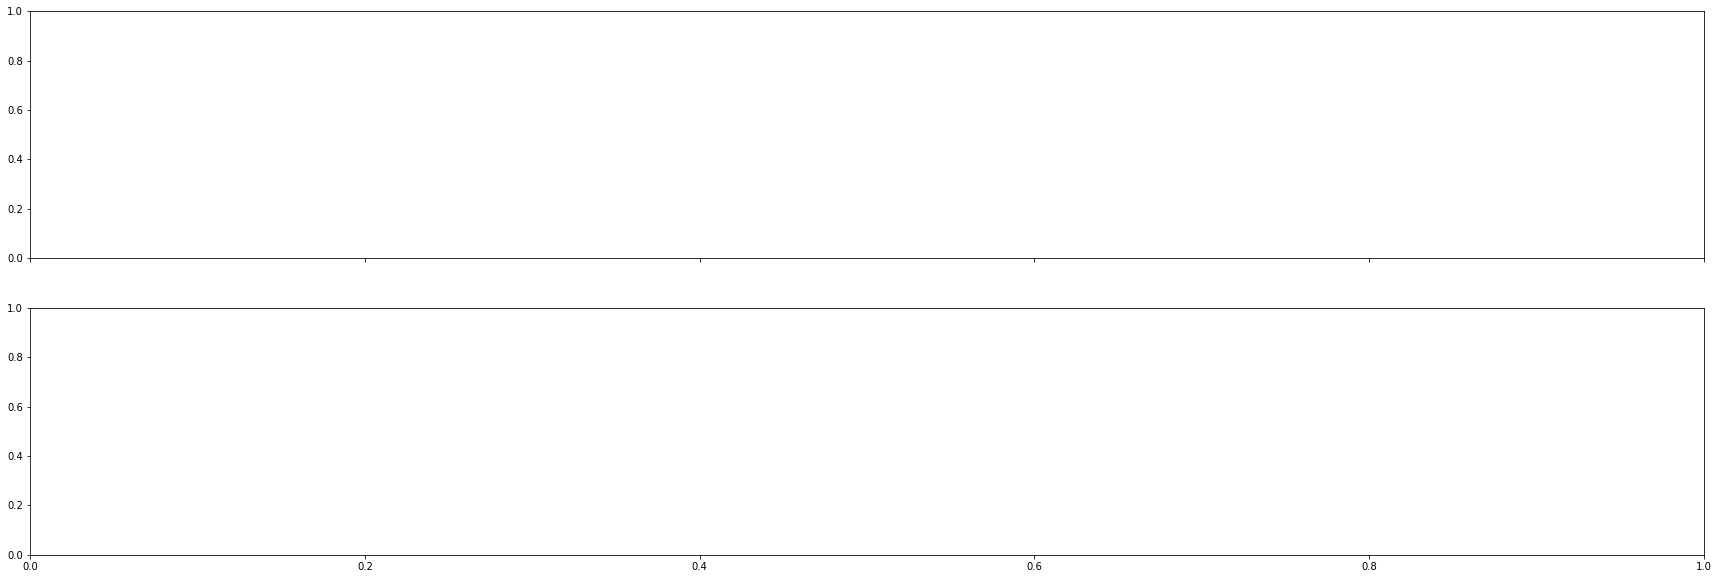

In [5]:
###############################################################################
        
num_epoch = 15

time_step_list = [128/2]
total_time_models = []

fig, ax_lst = plt.subplots(2, len(time_step_list), sharex=True, sharey='row',figsize=(30,10))

for i,step in enumerate(time_step_list):      
  spiking_model = SpikingConvNet(device, n_time_steps=int(step), begin_eval=0)
  loss, acc, time_m = train_many_epochs(spiking_model, epochs = num_epoch)
  total_time_models.append(time_m)
  ax_lst[0].plot(acc)
  ax_lst[0].set_title("Spiking Acc, n time steps = %d"%int(step))
  ax_lst[1].plot(loss)
  ax_lst[1].set_title("Spiking Loss, n time steps = %d"%int(step))